# Information Points Extractor


## Who is Running?

In [ ]:
#Matheus
project_root = "/content/drive/MyDrive/Mestrado/Deep Learning/Projeto"
#Gabi
#Jean
#Sandra

from google.colab import drive
drive.mount('/content/drive')

## General Parâmeters

In [ ]:
# Geneal parameters used on this notebook
study_case_name = "Anodorhynchus_hyacinthinus" #@param {type:"string"}

# Parameters for Raster_Information_Collector
min_absence_distance = 100 #@param {type:"integer"

Fixed Parameters

In [ ]:
# Geneal parameters used on this notebook
country_mask_reference =  project_root+"/Data/Standarized_Rasters/Base_Rasters/brazilian_mask_standarized.tif"
rasters_root_folders_list =  [project_root+"/Data/Rasters/Elevation_Rasters", project_root+"/Data/Rasters/Bioclim_Rasters",project_root+"/Data/Rasters/Envirem_Rasters"] 
occurrences_root = project_root+"/Data/GBIF_Ocurrences"
shapefiles_folder = project_root+'/Data/Shapefiles/Shapefiles_Brasil'
brazil_coordinate_points = project_root + "/Data/Standarized_Rasters/CSV_Aux_Files/brazil_coords.csv"

# Parameters for Raster_Standards
resolution = 0.00833333333333 
crs = 4326 
no_data_val = -9999.0
positive_mask_val = 255
negative_mask_val = 0
country_limits = (-73.981934,-34.792929, -33.750035, 5.271478)

# Parameters for Raster_Information_Collector
coorection_limit = 10
raster_information_collector_output_dir = project_root+"/Data/Rasters_As_Numpy_Arrays" 

#Parameters for Brazil
map_result_folder_path = project_root + "/Data/GBIF_Presence_Absence_Maps"

#Study Case Path
study_cases_root_folder = project_root+"/Data/Study_Cases"

# Main folder created on this file
presence_absence_folder_path = project_root + "/Data/Species_Presence_Absence"
species_env_info_folder_path = project_root + "/Data/Species_Enverionment_Info"


## Installs

In [ ]:
! pip install geopandas --quiet
! pip install rasterio --quiet
! pip install earthpy --quiet

## Retrieving aux Classes

In [ ]:
!wget https://raw.githubusercontent.com/math-sasso/extinction-prevention-modeling-MO434/main/Aux_Files/utils.py
!wget https://raw.githubusercontent.com/math-sasso/extinction-prevention-modeling-MO434/main/Aux_Files/brazil.py

--2020-12-13 17:32:44--  https://raw.githubusercontent.com/math-sasso/extinction-prevention-modeling-MO434/main/Aux_Files/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 800 [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]     800  --.-KB/s    in 0s      

2020-12-13 17:32:44 (96.9 MB/s) - ‘utils.py.1’ saved [800/800]

--2020-12-13 17:32:44--  https://raw.githubusercontent.com/math-sasso/extinction-prevention-modeling-MO434/main/Aux_Files/brazil.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 

In [ ]:
raster_base_configs = {'resolution':resolution,
                      'crs':crs,
                      'no_data_val':no_data_val,
                      'positive_mask_val':positive_mask_val,
                      'negative_mask_val':negative_mask_val,
                      'country_limits':country_limits,
                       'country_mask_reference':country_mask_reference}

In [ ]:
from utils import Utils
from brazil import Brazil
# from raster_standards import Raster_Standards

# raster_standards = Raster_Standards(raster_base_configs=raster_base_configs)
utils_methods = Utils()
brazil_object= Brazil(shapefiles_folder = shapefiles_folder,
                      country_limits=country_limits)

## Getting Specie Study Data

In [ ]:
import pandas as pd
import os
study_case_path =  os.path.join(study_cases_root_folder,study_case_name +'.csv')
study_information_df = pd.read_csv(study_case_path)
study_information_df

,GBIF_ID,Species_Name,Study_Focus
0,2434450,Chrysocyon brachyurus,True
1,2732686,Attalea maripa,False
2,7413879,Acrocomia aculeata,False
3,2732758,Attalea phalerata,False


In [ ]:
species_name = study_information_df[study_information_df['Study_Focus'] ==True]['Species_Name'][0]
taxonKey = study_information_df[study_information_df['Study_Focus'] ==True]['GBIF_ID'][0]
species_name_string = species_name.replace(" ","_")
print(f"species_name: {species_name} \ntaxonKey: {taxonKey} \nspecies_name_string: {species_name_string} \n ")

species_name: Chrysocyon brachyurus 
taxonKey: 2434450 
species_name_string: Chrysocyon_brachyurus 
 


## Creating Folder Structure

In [ ]:
utils_methods.create_folder_structure(presence_absence_folder_path)
utils_methods.create_folder_structure(species_env_info_folder_path)

## Raster Standards

In [ ]:
from typing import List,Tuple
import numpy as np
import os
import rasterio
from rasterio.enums import Resampling
from rasterio.plot import show


class Raster_Standards:
  
  """
  This class is reponsable for define all the raster base parametes used on the project and for applying operations on raster arrays

   Attributes
  ----------
  security_limt : int
    Limit to extrapolate territory boarders in all directions
  x_min_limit : float
      Country most western point considering security_limit
  x_max_limit : float
      Country most eastern point considering security_limit
  y_min_limit : float
      Country most south point considering security_limit
  y_max_limit : float
      Country most north point considering security_limit
  resolution : int
      Raster resolution
  crs : int
      CRS code for map projection
  no_data_val : int
      No data value
  positive_mask_val : int
      Positive mask value
  negative_mask_val : int
      Negative mask value
  xgrid : array
      Grid of values for refernce map on X
  ygrid : array
      Grid of values for refernce map on Y
  x_center_point : int
      Center point X coordinate
  y_center_point : int
      Center point Y coordinate
  """

  def __init__(self, raster_base_configs):
      """
      Parameters
      ----------
      raster_base_configs : Dict
          Configurations for raster Standards (resolution,crs,no_data_val,positive_mask_val,negative_mask_val and country_limits)
      """

      self.security_limt = 1
      country_limits = raster_base_configs['country_limits']
      self.x_min_limit = country_limits[0] -self.security_limt # Coordenadas DMS: 07°32′39″S 073°59′04″W; Coordenada Decimal Geohack: -7.544167, -73.984444; Corrdenada Decimal epsg.io: -7.535403, -73.981934
      self.x_max_limit = country_limits[1] +self.security_limt # Coordenadas DMS: 07°09′28″S 034°47′38″W; Coordenada Decimal Geohack: -20.474444, -28.840556; Corrdenada Decimal epsg.io: -7.155017, -34.792929
      self.y_min_limit = country_limits[2] -self.security_limt # Coordenadas DMS: 33°45′09″S 053°22′07″W; Coordenada Decimal Geohack: -33.7525, -53.368611; Corrdenada Decimal epsg.io: -33.750035, -53.407288
      self.y_max_limit = country_limits[3] +self.security_limt # Coordenadas DMS: 05°15′05″N 060°12′33″W; Coordenada Decimal Geohack: 5.251389, -60.209167; Corrdenada Decimal epsg.io: 5.271478, -60.214691
      self.resolution =  raster_base_configs['resolution']
      self.crs = raster_base_configs['crs']   #WGS84 EPSG:4326
      self.no_data_val = raster_base_configs['no_data_val'] 
      self.positive_mask_val = raster_base_configs['positive_mask_val']
      self.negative_mask_val = raster_base_configs['positive_mask_val']
      self.reference_raster = rasterio.open(raster_base_configs['country_mask_reference'])
      grids = self._construct_grids()
      self.xgrid = grids[0]
      self.ygrid = grids[1]
      self.x_center_point = np.median(self.xgrid)
      self.y_center_point = np.median(self.ygrid)

  

  def _construct_grids(self):
      """Construct the map grid from the batch object"""
      ref_aff = self.reference_raster.meta['transform']
      ref_width = self.reference_raster.profile['width']
      ref_heigh = self.reference_raster.profile['height']
      # X limits
      x_min_limit = ref_aff[2]
      x_max_limit = x_min_limit + ref_aff[0]*ref_width
      # Y limits
      y_max_limit = ref_aff[5]
      y_min_limit = y_max_limit + ref_aff[4]*ref_heigh


      xgrid = np.arange(x_min_limit, x_max_limit,ref_aff[0])
      ygrid = np.arange(y_min_limit, y_max_limit, ref_aff[0])


      return (xgrid,ygrid)


    
  def _reescale(self,raster_array,raster_object):
      """ Reescale a raster array on the desired resolution """
      if not (round(self.resolution,5) == round(raster_object.meta['transform'][0],5)):
        aux = self.resolution/raster.meta['transform'][0]
        reescale_factor = 1/aux

        # resample data to target shape
        data = raster_array.read(
            out_shape=(
                raster_array.count,
                int(raster_array.height * reescale_factor),
                int(raster_array.width * reescale_factor)
            ),
            resampling=Resampling.bilinear
        )

        # scale image transform
        transform = raster_array.transform * raster_array.transform.scale(
            (raster_array.width / data.shape[-1]),
            (raster_array.height / data.shape[-2])
        )
        data = data[0]
      else:
        data = raster_array
        transform = raster_object.meta['transform']
      return data,transform

  def _get_window_from_extent(self,aff):
    """ Get a portion form a raster array based on the country limits"""
    col_start, row_start = ~aff * (self.x_min_limit, self.y_max_limit)
    col_stop, row_stop = ~aff * (self.x_max_limit, self.y_min_limit)
    return ((int(row_start), int(row_stop)), (int(col_start), int(col_stop)))

  def _read_array_standarized(self,raster,raster_name):
      """ Performs verifications and standarizations for raster arrays """

      #1 Check if orientaion from Affine position 4 is negative
      res_n_s = raster.meta['transform'][4]
      if res_n_s > 0:
        raise Exception("Behavior not expected. The North South resolution is excpected to be negative")

      #2 Checking the number of raster layers 
      if raster.meta['count']>1:
        raise Exception("For some reason there are more than one layer in this raster")
      if raster.meta['count']==0:
        raise Exception("For some reason this raster is empty")

      #3 Checking CRS
      raster_code = int(raster.crs.data['init'].split(':')[1])
      if raster_code != self.crs:
        raise Exception("Sorry,crs from this raster is no EPSG:4326")
        # raster = raster.to_crs(epsg=self.crs)

      #4 Extracting only the window from Raster Standars Object
      raster_array = raster.read(1)


      #5 Resampling
      if not (round(self.reference_raster.meta['transform'][0],5) == round(raster.meta['transform'][0],5)):
         raise Exception(f"Files are not on the same resolution. That should be {round(self.reference_raster.meta['transform'][0],5)}")
      
      #6 converting nodata value if necessary
      if raster.nodata != self.no_data_val:
        raise Exception(f"Raster dont have default no data val. That should be {self.no_data_val}")


      #6 converting nodata value if necessary
      if raster.nodata != self.no_data_val:
        raise Exception(f"Raster dont have default no data val. That should be {self.no_data_val}")
        

      #7 Asserting that numpy array will be float32
      if raster.meta['dtype'] != self.reference_raster.meta['dtype']:
        raise Exception(f"Raster dont have default dtype. That should be {self.reference_raster.meta['dtype']}")
      
      #8 Setting raster to none. The information that matters is the rater aray
      raster = None

      return raster_array
  
  def get_land_reference_array_mask(self,land_reference_path):
      """ Returns the reference array mask conseidering scales and limits"""
      raster = rasterio.open(land_reference_path)
      raster_array = raster.read(1,window = self._get_window_from_extent(raster.meta['transform']))
      raster_array,_ = self._reescale(raster_array,raster)
      return raster_array

  def get_raster_array(self,path,print_example = False):
      """ Returns a raster array with all the standarizations applied"""
      #openning raster
      raster = rasterio.open(path)
      #get standarized raster array
      raster_array = self._read_array_standarized(raster,path.split("/")[-1])   
      return raster_array
    
  def get_rasters_from_dir(self,dir_path):
      """ Read all the .tif files on the standarized format and stack them"""
      rasters = []
      for (dirpath, dirnames, filenames) in os.walk(dir_path):
        dir_files_paths_list = sorted([os.path.join(dir_path, fname) for fname in filenames])
        for filepath,filename in zip(dir_files_paths_list,filenames):
          if filename.endswith('.tif'):
            raster_array  = self.get_raster_array(filepath)
            rasters.append(raster_array) 
            del raster_array
        break
      
      result =  np.stack([value for value in rasters])
      del rasters

      return result

  def get_land_reference_array_infos(self,country_mask_reference):
      """ Returns infos (raster_array,xgrid,ygrid) from a contry mask reference array"""
      raster = rasterio.open(country_mask_reference)
      resolution = raster.meta['transform'][0]
      raster_array = raster.read(1,window = self._get_window_from_extent(raster.meta['transform']))
      raster_array,_ = self._reescale(raster_array,raster)
      xgrid = np.arange(self.x_min_limit, self.x_min_limit+raster_array.shape[1]*resolution, resolution)
      ygrid = np.arange(self.y_min_limit, self.y_min_limit+raster_array.shape[0]*resolution, resolution)
      return raster_array,xgrid,ygrid
  

In [ ]:
raster_standards = Raster_Standards(raster_base_configs=raster_base_configs)

## Raster_Information_Collector


In [ ]:
from typing import List,Tuple
import gc
from sklearn.utils import Bunch
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.plot import show
from rasterio.windows import Window
from osgeo import gdal
import matplotlib.pyplot as plt
import geopy.distance
import os
import pandas as pd


class Raster_Information_Collector:
  """
  This class is reponsable for extracting data from rasters on GBIF occurrence locations

  Attributes
  ----------
  raster_base_configs : str
      Directory to save coverages
  coorection_limit : int
      Limit of iterations to correct no information points
  raster_standards : object
      Raster standards object
  """

  def __init__(self, output_dir:str,raster_standards,utils_methods,coorection_limit:int=10):
      """
      Parameters
      ----------
      raster_base_configs : str
          Directory to save coverages
      coorection_limit : int
          Limit of iterations to correct no information points
      raster_standards : object
          Raster standards object
      """

      self.output_dir = output_dir
      self.raster_standards = raster_standards
      self.utils_methods=utils_methods
      self.coorection_limit = coorection_limit
      self.species_presence_df = None
      self.species_absence_df = None
      self.env_info_species_presence_df = None
      self.env_info_species_absence_df = None

  def _treat_boarder_points(self,Long,Lat,ix,iy,raster_array,raster_occurrences_array):
      "Repair problems on points very near to the the country boarders by getting nearest values on the center point direction"

      for i,elem in enumerate(raster_occurrences_array):
        if elem == -9999.0:
          point_x,point_y = Long[i],Lat[i]
          base_point_x,base_point_y = point_x.copy(),point_y.copy()
          incx,incy = 0,0
          k = 0
          #walking coodinates in center map
          while (elem==-9999.0 and k<self.coorection_limit):
            if point_x >= self.raster_standards.x_center_point and  point_y >= self.raster_standards.y_center_point:
              point_x -= self.raster_standards.resolution
              point_y -= self.raster_standards.resolution
              incx -= 1
              incy -= 1
            if point_x >= self.raster_standards.x_center_point and  point_y <= self.raster_standards.y_center_point:
              point_x -= self.raster_standards.resolution
              point_y += self.raster_standards.resolution
              incx -= 1
              incy += 1
            if point_x <= self.raster_standards.x_center_point and  point_y <= self.raster_standards.y_center_point:
              point_x += self.raster_standards.resolution
              point_y += self.raster_standards.resolution
              incx += 1
              incy += 1
            if point_x <= self.raster_standards.x_center_point and  point_y >= self.raster_standards.y_center_point:
              point_x += self.raster_standards.resolution
              point_y -= self.raster_standards.resolution
              incx += 1
              incy -= 1           

            new_ix = ix[i]+incx
            new_iy = iy[i]+incy

            value = raster_array[-new_iy,new_ix].T
            if value != -9999.0:
              raster_occurrences_array[i] = value
              elem = value
              print(f"The raster coordniate info was changed from the point {(base_point_x,base_point_y)} to the point {(point_x,point_y)}")
            k+=1
      return raster_occurrences_array  

  def _fill_peristent_no_data_values_with_median_value(self,raster_occurrences_array):
      """ For grids that still with empty value after the board points treatment, this function fill it with the mean value"""

      median_value = np.median(raster_occurrences_array[[raster_occurrences_array!=-9999.0]])
      for i,elem in enumerate(raster_occurrences_array):
        if elem == -9999.0:
          raster_occurrences_array[i] = median_value
      
      return raster_occurrences_array

  def _get_coverage_from_coords(self,coordinates,list_raster_files,verbose):
    Long =  np.array([ t[1] for t in coordinates])
    Lat = np.array([ t[0] for t in coordinates])
    ix = np.searchsorted(self.raster_standards.xgrid,Long)
    iy = np.searchsorted(self.raster_standards.ygrid,Lat)

    all_env_values_list = []
    for i,fp in enumerate(list_raster_files):

        if verbose:
          print(f"Reading raster {fp.split('/')[-1]}")

        
        # Exctraction occurences from rasters
        raster_array = self.raster_standards.get_raster_array(fp)
        if verbose:
          plt.imshow(raster_array, cmap='terrain')
          plt.show()
        raster_occurrences_array = raster_array[-iy, ix].T
        
        #treating cases where points that should be inside country are outside
        # raster_occurrences_array = self._treat_boarder_points(Long,Lat,ix,iy,raster_array,raster_occurrences_array)
        
        if verbose:
          print(raster_occurrences_array)
        del raster_array

        #tretaing cases that still with no data values
        raster_occurrences_array= self._fill_peristent_no_data_values_with_median_value(raster_occurrences_array)
        
        #selecting the env value on the occurrence position
        all_env_values_list.append(raster_occurrences_array)

        del raster_occurrences_array
        gc.collect()

    coverage= np.stack([value for value in all_env_values_list]).T
    del ix
    del iy
    del all_env_values_list
    gc.collect() 

    print("------------------------------------------------------\n")
    return coverage


  def _update_coverages(self,species_name,coverage,coverage_type="presence"):
      """ Treats if a new numpy array is created or if an existing one is updated"""
      
      
      species_numpy_array_folder_path = f"{self.output_dir}/{species_name}"
      self.utils_methods.create_folder_structure(species_numpy_array_folder_path)

      numpy_array_path = f"{species_numpy_array_folder_path}/{species_name}_presence.npy" if coverage_type=="presence"  else f"{species_numpy_array_folder_path}/{species_name}_absence.npy"
      
      
      with open(numpy_array_path, 'wb') as f:
        np.save(f, coverage)



  def _get_distance_between_coords_in_km(self,coords_1:Tuple,coords_2:Tuple):
    return geopy.distance.vincenty(coords_1, coords_2).km

 
  def create_species_presence_df(self,specie_dir:str,species_name:str):
    species_presence_df = gpd.read_file(specie_dir)
    species_presence_df = species_presence_df[['LONGITUDE','LATITUDE']]
    species_presence_df['coords'] = species_presence_df[['LATITUDE', 'LONGITUDE']].apply(tuple, axis=1) 
    species_presence_df['presence/pseudo_absence'] = 1
    presence_absence_folder_path_species = f"{presence_absence_folder_path}/{species_name}"
    self.utils_methods.create_folder_structure(presence_absence_folder_path_species)
    final_path = f"{presence_absence_folder_path_species}/{species_name}_presence.csv"
    species_presence_df.to_csv(final_path,index = False, header=True)
    self.species_presence_df = species_presence_df
    
    return species_presence_df,final_path


  
  def create_env_info_species_presence_df(self,
                                          species_name:str,
                                          list_raster_files:List[str],
                                          list_names_raster:List[str],
                                          presence_absence_folder_path:str,
                                          species_env_info_folder_path:str,
                                          verbose:bool=False):
    
    """ Save all extracted to a numpy array"""
    if self.species_presence_df is None:
      raise Exception("You must read the presence dataframe before")

    coordinates = self.species_presence_df['coords'].to_numpy()
    coverage = self._get_coverage_from_coords(coordinates,list_raster_files,verbose)

    self._update_coverages(species_name,coverage,"presence")

    with open(f"{self.output_dir}/{species_name}/{species_name}_presence.npy", 'rb') as f:
            numpy_raster_info = np.load(f)
            env_info_species_presence_df = pd.DataFrame(numpy_raster_info,columns = list_names_raster)
            species_env_info_folder = f"{species_env_info_folder_path}/{species_name}"
            self.utils_methods.create_folder_structure(species_env_info_folder)
            final_path = f"{species_env_info_folder}/{species_name}_presence.csv"
            env_info_species_presence_df.to_csv(final_path,index = False, header=True)
            
    del coverage
    gc.collect()

    self.env_info_species_presence_df = env_info_species_presence_df

    return env_info_species_presence_df,final_path
  
  
  def create_species_absence_df(self,
                                species_name:str,
                                min_absence_distance:int,
                                presence_absence_folder_path:str,
                                brazil_coordinate_points_path:str,
                                verbose = False):
    

    # RETRIEVING NECESSARY DATAFRAMES
    df_species_occurrences = self.species_presence_df 
    df_species_env_info = self.env_info_species_presence_df
    df_brazil_coordinate_points = pd.read_csv(brazil_coordinate_points_path)
    df_brazil_coordinate_points['coords'] = list(zip(df_brazil_coordinate_points.latitude, df_brazil_coordinate_points.longitude))

    # ABSENCE OCURRENCES 
    df_brazil_coordinate_points_copy = df_brazil_coordinate_points.copy()
    df_brazil_coordinate_points_copy = df_brazil_coordinate_points_copy.sample(frac = 1) 
    number_of_presences = len(df_species_occurrences)
    number_of_absences = number_of_presences if number_of_presences < 2000 else 2000
    abs_row = 0
    dict_absences = {}
    while number_of_absences>0:
      step_reduction = 0
      # Recuperando uma parcela de todos os pontos possíveis
      df_brazil_possible_absence_points = df_brazil_coordinate_points_copy[:number_of_absences]
      # Iterando sobre os possíveis pontos de absência
      for i,row1 in df_brazil_possible_absence_points.iterrows():
        possible_coord = row1['coords']
        # Iterando sobre os pontos de presença já conhecindos
        for k,row2 in df_species_occurrences.iterrows():
          presence_coord = (row2['LATITUDE'],row2['LONGITUDE'])
          dist = self._get_distance_between_coords_in_km(presence_coord,possible_coord)
          if dist<min_absence_distance:
            if verbose:
              print(f"The coord {possible_coord} is not valid")
            possible_coord = None
            df_brazil_coordinate_points_copy = df_brazil_coordinate_points_copy.drop([i])
            df_brazil_possible_absence_points = df_brazil_possible_absence_points.drop([i])
            break
        if possible_coord:
          if verbose:
            print(f"The coord {possible_coord} is VALID")
          dict_absences[abs_row] = {'LONGITUDE':possible_coord[1], 'LATITUDE':possible_coord[0], 'coords': possible_coord,'presence/pseudo_absence':0}
          abs_row+=1
          step_reduction+=1

      number_of_absences = number_of_absences-step_reduction
      if verbose:
        print(f"{number_of_absences} absence points stills need to found")
      

    df_absences = pd.DataFrame.from_dict(dict_absences, "index") 
    presence_absence_folder_path_species = f"{presence_absence_folder_path}/{species_name}"
    self.utils_methods.create_folder_structure(presence_absence_folder_path_species)
    final_path = f"{presence_absence_folder_path_species}/{species_name}_absence.csv"
    df_absences.to_csv(final_path,index = False, header=True)
    self.species_absence_df = df_absences

    return df_absences,final_path

  def create_env_info_species_absence_df(self,
                                         species_name:str,
                                         list_raster_files:List[str],
                                         list_names_raster:List[str],
                                         presence_absence_folder_path:str,
                                         species_env_info_folder_path:str,
                                         verbose:bool=False):
    
    if self.species_absence_df is None:
      raise Exception("You must read the absence dataframe before")
    
    species_absence_df= self.species_absence_df
    coordinates = self.species_absence_df['coords'].to_numpy()
    coverage = self._get_coverage_from_coords(coordinates,list_raster_files,verbose)
    
    self._update_coverages(species_name,coverage,"absence")

    with open(f"{self.output_dir}/{species_name}/{species_name}_absence.npy", 'rb') as f:
            numpy_raster_info = np.load(f)
            env_info_species_absence_df = pd.DataFrame(numpy_raster_info,columns = list_names_raster)
            species_env_info_folder = f"{species_env_info_folder_path}/{species_name}"
            self.utils_methods.create_folder_structure(species_env_info_folder)
            final_path = f"{species_env_info_folder}/{species_name}_absence.csv"
            env_info_species_absence_df.to_csv(final_path,index = False, header=True)
    
    del coverage
    gc.collect()

    self.env_info_species_absence_df =  env_info_species_absence_df

    return env_info_species_absence_df,final_path

  def reset_dataframes(self):
      self.species_presence_df = None
      self.species_absence_df = None
      self.env_info_species_presence_df = None
      self.env_info_species_absence_df = None

## Creating Instances

Creating collector instance

In [ ]:
raster_collector = Raster_Information_Collector(output_dir=raster_information_collector_output_dir,raster_standards=raster_standards,utils_methods=utils_methods,coorection_limit=coorection_limit)

Retrieving list of rasters

In [ ]:
list_raster_files = open(project_root + '/Data/Standarized_Rasters/TXT_Aux_Files/list_raster_files.txt', 'r').read().splitlines()
list_names_raster = open(project_root + '/Data/Standarized_Rasters/TXT_Aux_Files/list_names_raster.txt', 'r').read().splitlines()

## Getting and Saving PRESENCE data

In [ ]:
specie_shp_path = os.path.join(occurrences_root,species_name_string,species_name_string+".shp")
species_presence_df,species_presence_path = raster_collector.create_species_presence_df(specie_dir = specie_shp_path,
                                                 species_name = species_name_string)
species_presence_df

,LONGITUDE,LATITUDE,coords,presence/pseudo_absence
0,-45.762356,-14.868054,"(-14.868054, -45.762356)",1
1,-45.877050,-14.868649,"(-14.868649, -45.87705)",1
2,-45.939742,-14.963383,"(-14.963383, -45.939742)",1
3,-47.626616,-15.966622,"(-15.966622, -47.626616)",1
4,-47.877723,-15.967905,"(-15.967905, -47.877723)",1
...,...,...,...,...
65,-43.487988,-20.097401,"(-20.097401, -43.487988)",1
66,-45.322208,-9.974261,"(-9.974261, -45.322208)",1
67,-56.261348,-18.816034,"(-18.816034, -56.261348)",1
68,-52.940804,-18.097723,"(-18.097723, -52.940804)",1


Reading raster bio1_annual_mean_temperature.tif


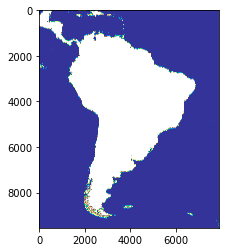

[22.783333 22.391666 22.729166 21.125    20.275    20.904167 20.420834
 21.141666 20.95     20.575    20.329166 20.925    20.425    20.95
 20.495832 20.320833 20.341667 20.3125   23.525    21.583334 21.4375
 24.908333 21.4375   21.516666 25.366667 21.875    24.545834 25.225
 23.15     24.508333 20.891666 18.575    20.075    19.966667 19.320833
 20.0625   19.758333 17.933334 20.341667 18.495834 18.158333 19.641666
 18.2      19.066668 19.254168 17.795834 15.929167 20.141666 15.9375
 24.0875   18.820833 19.783333 19.9      19.841667 19.608334 20.854166
 22.366667 22.116667 20.295834 21.420834 14.158334 20.9375   15.025
 16.695833 16.695833 16.695833 24.683332 25.466667 21.429167 24.883333]
Reading raster bio2_mean_diurnal_range.tif


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


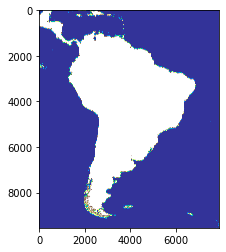

[12.483334 12.4      12.591666 11.366667 11.416666 10.608334 11.391666
 11.016666 11.266667 11.166667 10.925    11.083334 11.25     11.266667
 11.425    11.341666 11.233334 11.408333  9.533334 12.566667 12.741667
 12.083333 12.641666 12.383333 12.183333 10.65     12.441667 11.6
 11.783333 11.833333 12.083334 11.45     11.483334 11.75     10.591667
 11.675    11.45     11.033334 11.966667 10.858334 11.983334 11.383333
 11.366667 11.5      11.808333 11.125    11.075    12.       11.008333
 13.958334 10.975    12.016666 11.966666 11.983334 11.8      11.791667
 12.116667 12.150001 11.341666 11.858334 12.133333 11.758333 12.483334
 11.108334 11.108334 11.108334 14.       11.633333 12.641666 11.7     ]
Reading raster bio3_isothermality.tif


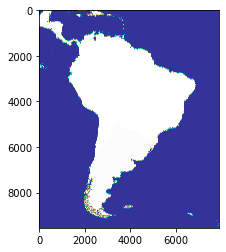

[70.52731  70.45455  70.344505 67.258385 67.15687  67.569    67.0098
 67.586914 67.87149  67.676765 68.28125  67.5813   67.36527  67.87149
 66.81287  67.11045  67.265465 66.7154   60.33755  67.20143  66.7103
 66.02914  67.60249  67.30072  66.21377  69.155846 68.3608   63.736267
 62.017544 63.62007  62.93403  63.61111  64.1527   64.20765  63.805225
 64.14835  64.68926  64.90196  64.336914 64.25049  67.3221   64.67803
 63.857677 63.88889  64.17572  64.30636  65.147064 63.157894 65.13807
 68.08943  61.657303 64.260254 63.99287  64.082    64.13043  63.396057
 63.438046 66.39344  63.717224 65.15568  58.054226 64.606224 59.162716
 64.21002  64.21002  64.21002  68.965515 63.224636 67.60249  62.566845]
Reading raster bio4_temperature_seasonality.tif


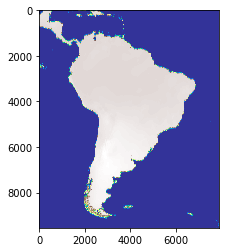

[125.28754  121.22168  126.42747  137.60123  122.167915 120.38684
 125.52542  120.35616  118.72428  111.58977  108.17618  122.40953
 124.47162  118.72428  127.26954  123.99522  121.259186 123.80566
 202.2993   166.35577  168.10611  127.22269  166.76228  168.08186
 130.5292    94.568405 148.0089   236.77281  265.7066   248.14615
 225.05386  210.75082  207.49042  210.42525  204.71107  208.80751
 202.78552  204.0425   214.59088  205.44254  189.01457  200.07764
 204.7504   207.94812  217.89758  198.53392  195.03447  230.0675
 193.40402  103.443565 221.37439  229.39972  226.59537  230.43272
 228.12311  246.49782  261.44992  218.81221  223.44879  219.45653
 258.85968  229.95183  316.60486  198.36214  198.36214  198.36214
  97.848045 227.52953  166.12508  256.07468 ]
Reading raster bio5_max_temperature_of_warmest_month.tif


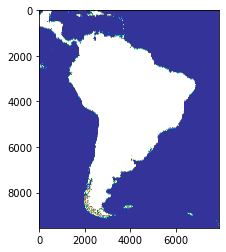

[30.8 30.3 30.7 28.3 27.8 27.7 27.9 28.3 28.3 27.9 27.5 28.1 27.8 28.3
 28.  27.8 27.7 27.9 31.2 29.4 29.5 32.9 29.2 29.2 33.3 28.9 32.4 33.1
 31.6 32.7 29.5 26.5 28.  28.  25.9 28.1 27.6 24.7 28.6 25.2 25.9 27.4
 26.  27.  26.6 25.4 23.3 27.7 23.3 34.2 27.1 27.4 27.5 27.5 27.1 28.6
 30.8 29.5 27.7 28.9 23.6 28.6 25.  24.3 24.3 24.3 34.7 33.5 29.2 33. ]
Reading raster bio6_min_temperature_of_coldest_month.tif


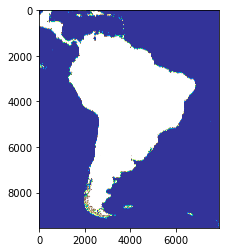

[13.1 12.7 12.8 11.4 10.8 12.  10.9 12.  11.7 11.4 11.5 11.7 11.1 11.7
 10.9 10.9 11.  10.8 15.4 10.7 10.4 14.6 10.5 10.8 14.9 13.5 14.2 14.9
 12.6 14.1 10.3  8.5 10.1  9.7  9.3  9.9  9.9  7.7 10.   8.3  8.1  9.8
  8.2  9.   8.2  8.1  6.3  8.7  6.4 13.7  9.3  8.7  8.8  8.8  8.7 10.
 11.7 11.2  9.9 10.7  2.7 10.4  3.9  7.   7.   7.  14.4 15.1 10.5 14.3]
Reading raster bio7_temperature_annual_range.tif


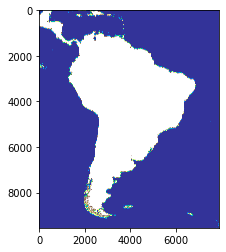

[17.699999 17.599998 17.900002 16.9      17.       15.700001 17.
 16.3      16.599998 16.5      16.       16.400002 16.699999 16.599998
 17.1      16.9      16.7      17.099998 15.800001 18.7      19.1
 18.300001 18.7      18.400002 18.4      15.4      18.2      18.199999
 19.       18.6      19.2      18.       17.9      18.3      16.599998
 18.2      17.7      17.       18.6      16.900002 17.8      17.599998
 17.8      18.       18.400002 17.3      17.       19.       16.9
 20.5      17.8      18.7      18.7      18.7      18.400002 18.6
 19.099998 18.3      17.800001 18.2      20.9      18.2      21.1
 17.3      17.3      17.3      20.300001 18.4      18.7      18.7     ]
Reading raster bio8_mean_temperature_of_wettest_quarter.tif


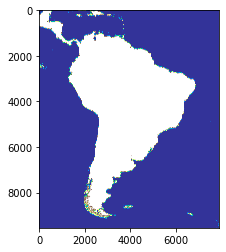

[23.366667 22.95     23.333334 21.866667 20.883333 21.516666 21.05
 21.75     21.533333 21.083334 20.8      21.533333 21.066668 21.533333
 21.15     20.933334 20.933334 20.95     25.083334 22.7      22.516666
 25.433334 22.6      22.699999 25.966667 22.116667 25.733334 27.333334
 25.766666 26.866667 22.683334 20.3      21.7      21.666668 21.1
 21.7      21.333332 19.766666 22.066668 20.300001 19.683334 21.216667
 19.866667 20.733334 21.15     19.4      17.566666 22.15     17.55
 24.4      21.4      22.033333 22.133333 22.133333 21.85     23.35
 25.133333 24.083334 22.5      23.483334 17.166666 23.233334 13.583333
 18.316668 18.316668 18.316668 24.65     27.366667 22.566666 27.35    ]
Reading raster bio9_mean_temperature_of_driest_quarter.tif


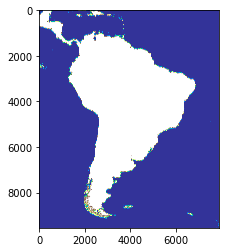

[21.016666 20.7      20.933332 19.166666 18.583334 19.2      18.666666
 19.45     19.316668 19.016666 18.85     19.183332 18.683332 19.316668
 18.716667 18.6      18.65     18.583334 21.       19.3      19.15
 23.266666 19.15     19.233334 23.583334 20.65     22.416666 21.966667
 19.65     21.15     17.816666 15.683333 17.233334 17.083334 16.45
 17.2      16.966667 15.083333 17.416666 15.633333 15.566668 16.9
 15.383333 16.216667 16.166666 15.083334 13.25     16.883333 13.283333
 22.883333 16.066668 16.683334 16.833332 16.733334 16.533333 17.533333
 20.283333 19.15     17.266666 18.45     10.85     17.85     11.15
 13.966667 13.966667 13.966667 23.633333 22.300001 19.15     21.416666]
Reading raster bio10_mean_temperature_of_warmest_quarter.tif


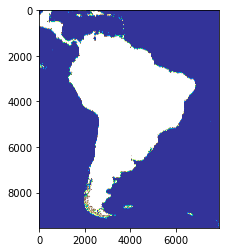

[23.916666 23.516666 23.833334 22.1      21.283333 21.75     21.4
 22.033333 21.866667 21.45     21.2      21.816666 21.383333 21.866667
 21.5      21.3      21.283333 21.3      26.       22.95     22.866667
 26.166668 22.816668 22.916666 26.566666 22.783333 25.733334 27.383333
 25.883333 26.866667 23.35     20.833334 22.316668 22.216667 21.283333
 22.3      21.933334 19.933334 22.65     20.466667 20.15     21.783333
 20.383333 21.3      21.383333 19.95     18.033333 22.383333 18.033333
 25.45     21.533333 22.05     22.133333 22.133333 21.883333 23.366667
 25.133333 24.083334 22.533333 23.516666 17.166668 23.25     18.766666
 18.833334 18.833334 18.833334 25.983334 27.483334 22.8      27.35    ]
Reading raster bio11_mean_temperature_of_coldest_quarter.tif


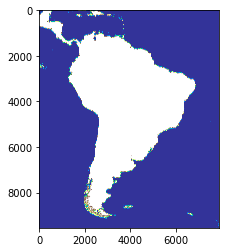

[21.016666 20.683332 20.933332 19.1      18.466667 19.133333 18.566668
 19.366667 19.183334 18.933332 18.733334 19.133333 18.583334 19.183334
 18.616667 18.483334 18.55     18.483334 21.       19.133333 18.95
 23.05     18.983334 19.033333 23.466667 20.566666 22.416666 21.966667
 19.65     21.133333 17.816666 15.683333 17.233334 17.083334 16.45
 17.2      16.966667 15.083333 17.416666 15.633333 15.566668 16.9
 15.383333 16.216667 16.166666 15.083334 13.25     16.883333 13.283333
 22.866667 16.066668 16.65     16.8      16.716667 16.5      17.533333
 18.783333 19.       17.266666 18.35     10.85     17.85     11.15
 13.966667 13.966667 13.966667 23.55     22.300001 18.983334 21.416666]
Reading raster bio12_annual_precipitation.tif


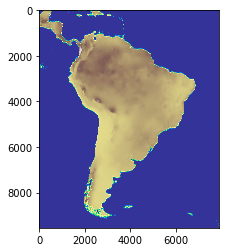

[1520. 1549. 1672. 1479. 1536. 1487. 1519. 1505. 1526. 1526. 1515. 1502.
 1529. 1526. 1524. 1523. 1513. 1539. 1249. 1612. 1612. 1625. 1609. 1593.
 1605. 1632. 1460. 1331. 1339. 1336. 1355. 1515. 1459. 1461. 1617. 1458.
 1476. 1667. 1439. 1648. 1571. 1479. 1540. 1518. 1616. 1587. 1650. 1591.
 1645. 1016. 1649. 1555. 1564. 1544. 1535. 1293. 1186. 1489. 1368. 1386.
 1808. 1338. 1754. 1614. 1614. 1614. 1049. 1305. 1609. 1278.]
Reading raster bio13_precipitation_of_wettest_month.tif


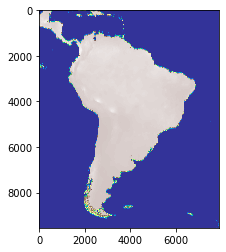

[333. 336. 362. 275. 270. 259. 269. 253. 255. 248. 245. 261. 270. 255.
 273. 267. 263. 272. 195. 308. 304. 284. 306. 299. 285. 284. 227. 225.
 182. 211. 294. 316. 308. 310. 296. 310. 311. 305. 307. 302. 326. 311.
 318. 316. 302. 323. 327. 302. 327. 181. 276. 271. 272. 270. 269. 242.
 162. 266. 240. 245. 303. 236. 185. 324. 324. 324. 200. 226. 307. 203.]
Reading raster bio14_precipitation_of_driest_month.tif


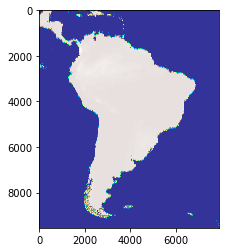

[  2.   2.   2.   6.   8.   7.   8.   8.   8.   9.   9.   7.   8.   8.
   8.   8.   8.   8.  52.  21.  21.   8.  21.  23.   6.   5.  16.  31.
  42.  31.  13.  15.  16.  15.  16.  15.  15.  19.  15.  17.  14.  15.
  16.  17.  17.  20.  20.  13.  19.   0.  38.  24.  24.  23.  24.  21.
  37.  22.  25.  23.  32.  21. 105.  20.  20.  20.   0.  28.  21.  32.]
Reading raster bio15_precipitation_seasonality.tif


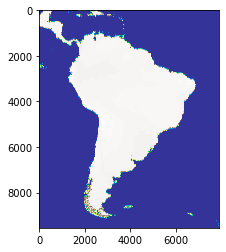

[93.63349  92.85252  93.73549  83.74802  79.30846  79.62463  79.65833
 78.443794 77.498055 76.60094  76.26591  79.74214  79.9343   77.498055
 80.309654 79.47592  78.97376  79.451584 48.257256 70.83396  69.95681
 81.03806  70.45645  69.20351  83.16694  83.652885 68.68294  58.895428
 43.002686 52.45752  83.61909  82.704094 82.518364 82.86751  77.714325
 83.16156  82.93452  75.778046 83.09645  76.78278  86.70754  83.42042
 82.44955  81.516846 77.22169  80.24701  80.6819   79.318115 80.98894
 88.59766  61.68014  71.298164 71.226906 71.76067  71.29373  73.63959
 43.62588  74.142235 71.49497  72.237114 68.86895  74.001366 15.80038
 80.5695   80.5695   80.5695   89.30926  62.5954   70.76971  52.951996]
Reading raster bio16_precipitation_of_wettest_quarter.tif


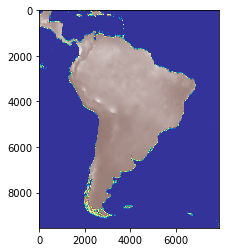

[858. 864. 943. 746. 743. 722. 737. 721. 726. 719. 713. 730. 745. 726.
 744. 736. 731. 747. 528. 765. 762. 797. 762. 751. 786. 809. 656. 598.
 507. 567. 726. 811. 779. 781. 828. 781. 791. 840. 770. 836. 869. 797.
 824. 806. 827. 840. 878. 824. 877. 503. 744. 758. 761. 755. 750. 654.
 442. 739. 671. 681. 870. 670. 494. 858. 858. 858. 529. 597. 763. 543.]
Reading raster bio17_precipitation_of_driest_quarter.tif


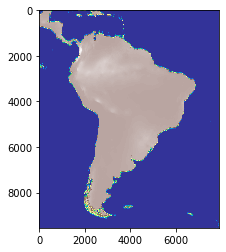

[ 14.  13.  13.  24.  29.  28.  29.  29.  31.  32.  32.  28.  29.  31.
  29.  28.  29.  29. 163.  72.  74.  31.  74.  78.  25.  20.  54. 106.
 144. 122.  43.  53.  54.  53.  57.  52.  53.  68.  51.  62.  48.  52.
  56.  60.  63.  69.  68.  55.  67.   2. 137.  94.  94.  91.  94.  82.
 143.  82.  85.  81. 119.  78. 397.  69.  69.  69.   2.  91.  72. 119.]
Reading raster bio18_precipitation_of_warmest_quarter.tif


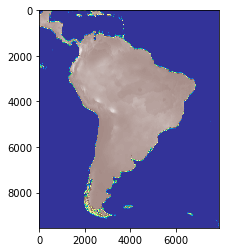

[410. 412. 450. 391. 428. 411. 422. 420. 432. 437. 436. 416. 423. 432.
 419. 425. 423. 429. 337. 577. 577. 452. 575. 570. 444. 470. 656. 563.
 499. 567. 540. 629. 600. 601. 719. 601. 612. 723. 590. 725. 687. 616.
 644. 625. 705. 654. 689. 710. 687. 242. 669. 677. 761. 755. 676. 598.
 442. 739. 596. 599. 788. 605. 456. 669. 669. 669. 246. 571. 577. 543.]
Reading raster bio19_precipitation_of_coldest_quarter.tif


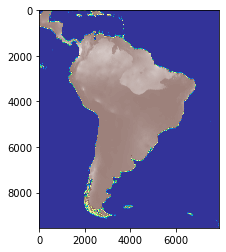

[ 14.  32.  13.  39.  48.  46.  47.  49.  51.  53.  55.  46.  47.  51.
  46.  48.  48.  48. 163. 106. 108.  48. 107. 111.  43.  38.  54. 106.
 144. 181.  43.  53.  54.  53.  57.  52.  53.  68.  51.  62.  48.  52.
  56.  60.  63.  69.  68.  55.  67.  16. 137. 113. 113. 110. 112.  82.
 192. 108.  85. 109. 119. 101. 397.  69.  69.  69.  13.  91. 104. 119.]
Reading raster elev1_strm_worldclim_elevation.tif


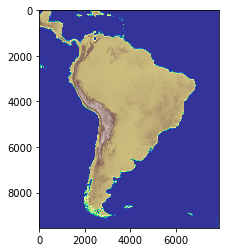

[ 803.  889.  802.  942. 1145. 1034. 1101. 1021. 1090. 1104. 1191. 1024.
 1118. 1090. 1095. 1120. 1127. 1140.   32.  812.  840.  370.  840.  837.
  273. 1017.  240.  114.  399.  171.  597. 1049.  783.  814. 1060.  795.
  857. 1313.  743. 1209. 1265.  883. 1114.  974. 1020. 1206. 1583.  816.
 1574.  570.  804.  862.  846.  839.  879.  566.  297.  531.  732.  607.
 1606.  659. 1234. 1409. 1409. 1409.  505.  122.  841.  119.]
Reading raster elev2_envirem_terrain_roughness_index.tif


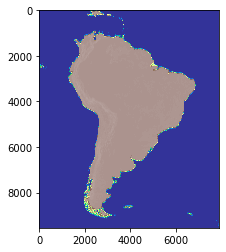

[ 15.75  18.75  19.75  38.    10.62  28.75  22.88  14.62  14.75  13.5
  27.38  20.25  26.25  14.75  28.5   27.12  17.38  12.5   26.75  22.38
   9.5   12.88   9.62   5.88   1.38  64.88  17.25   1.12  30.5    7.12
  36.75 126.75  23.25  31.12  92.75  31.88  41.38  42.38  10.12  80.12
  45.25  68.25 207.25 155.12 108.    98.   138.12  35.    80.38  20.12
  32.    14.25  15.88   9.    21.5   15.25  16.25  23.    28.5   22.5
  79.5   15.12   9.75 141.62 141.62 141.62  26.62   0.88   6.75   4.12]
Reading raster elev3_envirem_topographic_wetness_index.tif


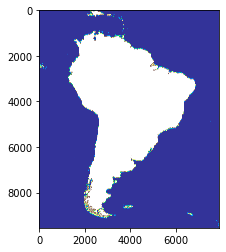

[11.71 11.43 11.45 10.36 11.58 10.77 11.38 11.16 11.93 11.03 10.82 10.96
 10.41 11.93 10.32 11.01 11.44 11.07 10.8  11.21 12.39 11.28 11.9  12.51
 11.81  9.88 10.34 14.48 11.05 12.43 10.38  7.43  8.98  9.24  8.77 10.12
  8.77  9.4  10.89  8.77 10.41  9.35  7.53  7.26  8.41  8.15  8.95 10.58
  8.32 11.19 10.43 11.12 10.4  10.33 10.5  11.14 11.7  10.44 10.78 11.4
  7.83 10.87 11.62  7.66  7.66  7.66 10.99 14.45 12.36 13.82]
Reading raster envir1_annual_PET.tif


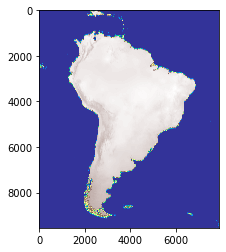

[1714.26 1681.23 1700.13 1598.58 1526.88 1539.05 1538.6  1532.59 1514.7
 1498.34 1477.99 1541.2  1535.87 1514.7  1537.58 1531.12 1526.21 1529.5
 1403.03 1656.41 1647.13 1718.   1644.88 1641.85 1739.   1538.75 1728.66
 1714.93 1641.43 1698.84 1566.79 1422.65 1506.65 1506.3  1423.03 1505.73
 1492.6  1386.81 1512.11 1403.4  1452.27 1493.84 1435.35 1457.61 1510.72
 1398.51 1313.75 1582.32 1315.51 1899.37 1334.56 1510.19 1522.68 1508.34
 1494.97 1500.13 1640.58 1605.33 1453.71 1564.62 1245.44 1506.03 1310.41
 1346.66 1346.66 1346.66 1895.4  1713.53 1649.47 1698.57]
Reading raster envir2_aridity_index_thornthwaite.tif


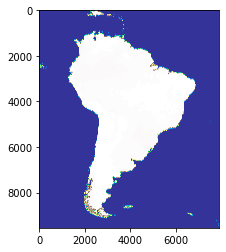

[56.49 61.2  55.56 61.71 80.59 81.51 80.76 82.36 79.41 81.92 80.61 80.84
 81.23 79.41 67.78 80.31 79.89 67.04 29.48 47.39 46.34 65.62 46.09 45.27
 66.39 71.76 56.17 38.9  22.02 29.39 56.11 56.05 63.04 63.06 61.44 62.89
 62.48 56.74 63.08 58.97 58.93 62.68 57.63 59.54 53.45 53.68 65.01 58.84
 65.27 63.17 41.03 44.69 45.28 45.55 46.17 44.77 27.77 51.68 47.21 52.72
 41.5  52.63 14.19 46.39 46.39 46.39 63.41 42.08 46.75 33.55]
Reading raster envir3_climatic_moisture_index.tif


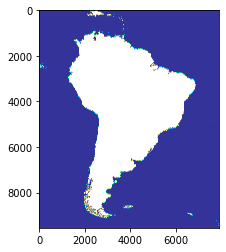

[-0.3  -0.27 -0.3  -0.09  0.02  0.07  0.06  0.03  0.14 -0.02 -0.02  0.11
  0.02  0.14 -0.    0.07  0.07  0.01 -0.19 -0.01 -0.   -0.08 -0.   -0.01
 -0.11  0.11 -0.15 -0.22 -0.17 -0.2  -0.18  0.05 -0.08 -0.09  0.07 -0.08
 -0.05  0.14 -0.09  0.1   0.05 -0.05  0.03 -0.01 -0.01  0.1   0.21 -0.11
  0.21 -0.46  0.19  0.03  0.02  0.03  0.03 -0.13 -0.28 -0.08 -0.04 -0.1
  0.32 -0.11  0.31  0.17  0.17  0.17 -0.45 -0.25 -0.   -0.23]
Reading raster envir4_continentality.tif


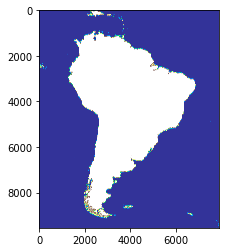

[3.8  3.7  3.7  3.65 3.55 3.4  3.35 3.4  3.3  3.15 3.15 3.4  3.4  3.3
 3.45 3.45 3.45 3.45 5.2  4.1  4.1  3.2  4.   4.15 3.   2.9  3.85 5.6
 6.9  6.3  6.15 5.85 5.9  5.95 5.25 6.   5.75 5.25 5.85 5.25 5.5  5.85
 5.8  5.8  5.9  5.55 5.25 6.25 5.3  2.95 6.3  6.45 6.5  6.45 6.35 6.6
 7.15 5.5  5.85 5.85 6.3  5.95 8.55 5.35 5.35 5.35 2.75 5.55 4.15 6.35]
Reading raster envir5_embergers_pluviothermic_quotient.tif


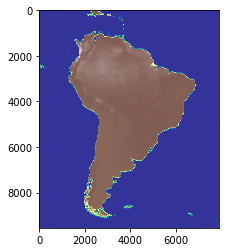

[229.47 240.41 231.51 291.58 330.26 359.01 347.93 349.87 391.69 331.97
 332.66 372.41 331.5  391.69 321.89 349.32 350.59 327.31 279.87 317.52
 316.58 321.69 320.41 319.27 315.29 402.35 277.69 258.98 246.44 252.88
 232.31 288.43 258.7  256.65 313.35 257.53 267.48 328.9  257.36 321.52
 289.7  266.07 284.08 274.82 277.41 305.94 342.99 246.7  340.3  171.38
 338.22 279.36 276.26 277.22 278.88 240.47 204.22 275.08 279.85 262.54
 339.03 255.84 315.03 327.09 327.09 327.09 180.13 251.98 319.3  245.57]
Reading raster envir6_growing_deg_days_0.tif


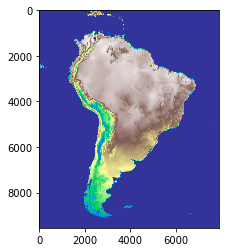

[ 99738.  98028.  99810.  93204.  88506.  91602.  89442.  92916.  90846.
  91962.  90468.  91494.  89064.  90846.  88812.  89226.  89388.  88506.
 106470.  97596.  96858. 110376.  96894.  97038. 112410.  98928. 109152.
 110286. 100386. 106200.  93438.  80784.  88200.  88416.  82584.  88200.
  86472.  77256.  88830.  79488.  78984.  86580.  81972.  84024.  84024.
  77976.  68958.  88992.  69156. 105282.  82764.  85680.  86706.  85770.
  84798.  88866.  97380.  94536.  86994.  92142.  60876.  89118.  65106.
  72630.  72630.  72630. 107298. 111762.  97092. 108270.]
Reading raster envir7_growing_deg_days_5.tif


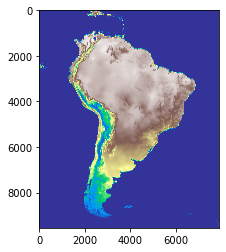

[ 99738.  98028.  99810.  93204.  88506.  91602.  89442.  92916.  90846.
  91962.  90468.  91494.  89064.  90846.  88812.  89226.  89388.  88506.
 106470.  97596.  96858. 110376.  96894.  97038. 112410.  98928. 109152.
 110286. 100386. 106200.  93438.  80784.  88200.  88416.  82584.  88200.
  86472.  77256.  88830.  79488.  78984.  86580.  81972.  84024.  84024.
  77976.  68958.  88992.  69156. 105282.  82764.  85680.  86706.  85770.
  84798.  88866.  97380.  94536.  86994.  92142.  60876.  89118.  65106.
  72630.  72630.  72630. 107298. 111762.  97092. 108270.]
Reading raster envir8_max_temp_coldest.tif


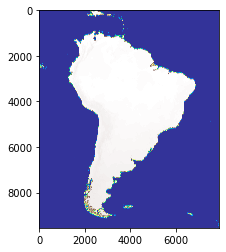

[281. 276. 281. 263. 249. 256. 253. 257. 253. 253. 249. 256. 252. 253.
 251. 251. 251. 250. 264. 273. 271. 303. 271. 270. 309. 272. 292. 279.
 253. 268. 250. 219. 239. 238. 224. 238. 236. 214. 240. 218. 224. 236.
 223. 228. 234. 215. 195. 246. 195. 313. 215. 233. 235. 233. 231. 234.
 250. 259. 227. 246. 180. 238. 171. 204. 204. 204. 316. 284. 271. 271.]
Reading raster envir9_min_temp_warmest.tif


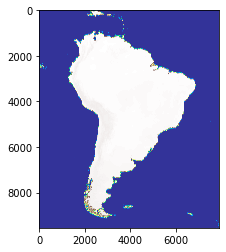

[184. 181. 185. 167. 158. 167. 159. 171. 166. 169. 167. 166. 159. 166.
 157. 159. 161. 157. 232. 180. 178. 205. 178. 180. 209. 187. 218. 223.
 204. 213. 186. 158. 174. 174. 165. 174. 169. 152. 175. 157. 153. 171.
 160. 165. 167. 151. 131. 178. 131. 184. 174. 170. 172. 170. 168. 181.
 200. 187. 175. 183. 117. 178. 132. 139. 139. 139. 190. 229. 179. 220.]
Reading raster envir10_month_count_by_temp_10.tif


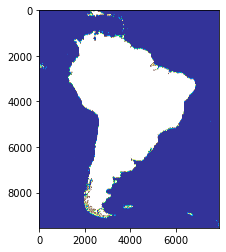

[12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.]
Reading raster envir11_PET_coldest_quarter.tif


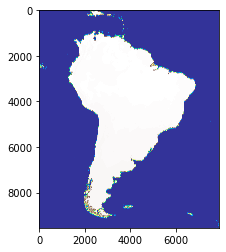

[117.46 115.39 116.55 108.93 103.09 104.65 104.03 104.39 102.57 101.53
 100.29 104.59 103.93 102.57 103.95 103.5  103.19 103.4   84.82 107.08
 106.35 119.16 105.98 105.16 121.44 108.06 115.36 106.04  89.   100.68
 100.34  90.48  96.61  96.37  88.56  96.47  90.34  86.11  96.77  87.11
  88.46  90.6   91.6   93.24  94.75  84.19  78.85  98.9   78.89 140.22
  80.4   94.    94.63  93.83  92.98  89.73  90.81  95.58  83.95  91.71
  77.18  87.05  67.73  81.    81.    81.   141.01 103.   106.16 100.48]
Reading raster envir12_PET_driest_quarter.tif


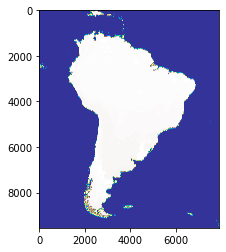

[123.62 121.69 123.01 114.55 108.43 110.13 109.38 110.07 108.   107.62
 106.52 109.97 109.28 108.   109.2  108.84 108.62 108.94  84.82 114.17
 113.21 126.89 113.04 112.23 129.33 115.57 123.04 106.04  94.93 100.68
 100.34  90.48  96.61  96.37  95.4   96.47  95.83  92.49  96.77  93.73
  93.35  96.02  91.6   93.24 100.94  89.33  83.44 105.19  83.58 149.22
  80.4   94.    94.63  93.83  92.98  89.73 114.89 101.71  88.16  96.24
  77.18  91.34 117.41  85.68  85.68  85.68 149.64 109.5  113.42 100.48]
Reading raster envir13_PET_seasonality.tif


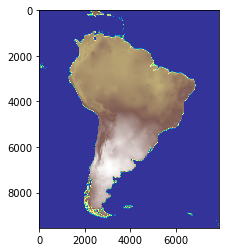

[1741.46 1686.53 1712.41 1657.38 1655.22 1623.18 1651.46 1609.98 1628.72
 1611.45 1593.45 1631.54 1654.78 1628.72 1653.74 1646.87 1645.83 1641.8
 2779.45 2178.65 2184.14 1642.74 2181.87 2224.84 1605.12 1364.91 2152.5
 3186.62 3582.4  3476.06 2644.7  2431.82 2537.78 2529.19 2121.31 2536.87
 2495.74 2092.42 2540.19 2111.49 2393.95 2485.93 2425.68 2452.06 2224.85
 2368.87 2261.79 2348.33 2274.11 1590.56 2697.63 2702.02 2727.13 2697.22
 2676.41 2934.03 3399.18 2733.98 2774.04 2859.13 2277.74 2845.71 3646.96
 2307.9  2307.9  2307.9  1519.31 2947.53 2194.34 3501.15]
Reading raster envir14_PET_warmest_quarter.tif


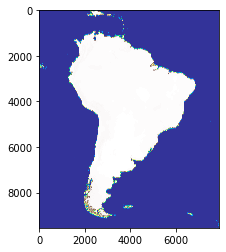

[156.98 152.93 154.94 144.19 138.16 137.87 139.3  136.66 135.55 129.31
 127.29 138.43 138.51 135.55 139.23 138.47 137.18 138.29 144.66 156.3
 155.41 155.62 155.   154.75 154.18 136.35 152.3  176.13 173.44 176.12
 156.07 141.18 149.28 149.06 132.21 149.28 147.44 129.9  149.76 137.72
 142.67 147.39 142.14 144.13 142.19 138.51 129.72 148.95 130.11 178.9
 137.41 146.28 147.57 146.13 144.36 148.08 170.76 152.29 144.39 152.99
 123.34 148.28 150.84 133.27 133.27 133.27 177.54 172.91 155.54 176.6 ]
Reading raster envir15_PET_wettest_quarter.tif


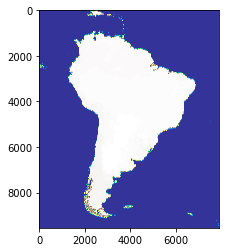

[155.42 152.51 154.2  147.88 142.18 143.34 143.32 142.77 141.47 139.99
 138.42 143.36 143.06 141.47 143.03 142.59 142.67 142.18 147.62 157.29
 156.83 156.81 156.57 156.22 157.67 138.37 152.3  172.86 175.69 176.12
 156.21 142.8  150.58 150.34 139.49 150.39 149.13 136.35 150.88 137.67
 145.18 149.1  143.68 145.69 147.74 140.21 132.71 155.01 133.11 164.88
 143.04 152.03 153.21 152.16 150.62 156.66 170.76 159.69 152.25 161.37
 128.28 156.65 102.83 135.78 135.78 135.78 159.97 168.93 156.94 176.6 ]
Reading raster envir16_thermicity_index.tif


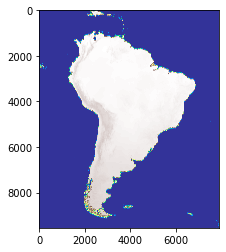

[594.  581.  594.  545.5 513.5 536.  520.5 545.  531.  538.5 528.5 536.
 518.  531.  514.5 517.5 520.5 513.5 654.  579.  573.  666.  573.  574.5
 681.  594.  645.5 659.  594.  632.  551.5 461.5 514.  514.5 470.5 513.
 501.5 435.5 517.5 449.5 454.  501.5 470.  483.  481.  443.5 384.5 513.5
 386.  637.5 483.  491.5 498.  491.5 485.5 515.  571.5 551.  502.5 536.5
 325.  516.5 357.5 409.5 409.5 409.5 651.5 670.5 575.5 647.5]
------------------------------------------------------



In [ ]:
env_info_species_presence_df,env_info_species_presence_path = raster_collector.create_env_info_species_presence_df(species_name=species_name_string,
                                                                   list_raster_files=list_raster_files,
                                                                   list_names_raster=list_names_raster,
                                                                   presence_absence_folder_path=presence_absence_folder_path,
                                                                   species_env_info_folder_path=species_env_info_folder_path,
                                                                   verbose = True)

## Getting and Saving ABSENCE data

In [ ]:
species_absence_df,species_absence_path = raster_collector.create_species_absence_df(species_name = species_name_string,
                      min_absence_distance = min_absence_distance,
                      presence_absence_folder_path = presence_absence_folder_path,
                      brazil_coordinate_points_path = f"{project_root}/Data/Country_Coords_Dataframes_WGS84/brazil_coords.csv",
                      verbose = True)

The coord (-2.216666666666633, -49.52499999999999) is VALID
The coord (-6.341666666666633, -40.674999999999976) is VALID
The coord (-9.133333333333297, -61.60833333333333) is VALID
The coord (-18.491666666666635, -48.6) is VALID
The coord (-5.549999999999965, -49.96666666666666) is VALID
The coord (-2.4333333333332985, -60.25) is VALID
The coord (-1.574999999999967, -50.80833333333333) is VALID
The coord (-12.666666666666632, -53.56666666666666) is VALID
The coord (-5.183333333333298, -68.96666666666667) is VALID
The coord (2.3000000000000327, -60.99166666666667) is VALID
The coord (-2.4083333333332995, -69.10833333333335) is VALID
The coord (-29.549999999999965, -52.99166666666666) is VALID
The coord (-12.791666666666632, -38.44166666666665) is VALID
The coord (-6.916666666666633, -51.41666666666666) is VALID
The coord (-3.116666666666632, -40.89166666666665) is VALID
The coord (-4.199999999999966, -45.61666666666665) is VALID
The coord (-21.158333333333303, -57.01666666666666) is not

In [ ]:
species_absence_df

,LONGITUDE,LATITUDE,coords,presence/pseudo_absence
0,-49.525000,-2.216667,"(-2.216666666666633, -49.52499999999999)",0
1,-40.675000,-6.341667,"(-6.341666666666633, -40.674999999999976)",0
2,-61.608333,-9.133333,"(-9.133333333333297, -61.60833333333333)",0
3,-48.600000,-18.491667,"(-18.491666666666635, -48.6)",0
4,-49.966667,-5.550000,"(-5.549999999999965, -49.96666666666666)",0
...,...,...,...,...
65,-61.608333,-9.133333,"(-9.133333333333297, -61.60833333333333)",0
66,-48.600000,-18.491667,"(-18.491666666666635, -48.6)",0
67,-49.966667,-5.550000,"(-5.549999999999965, -49.96666666666666)",0
68,-60.250000,-2.433333,"(-2.4333333333332985, -60.25)",0


Reading raster bio1_annual_mean_temperature.tif


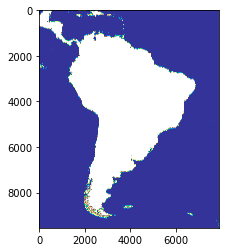

[26.408333 24.233334 25.291666 23.2      25.920834 26.420834 26.0375
 24.533333 26.070833 27.441668 26.075    18.2      24.783333 25.1
 27.433334 26.583334 25.983334 19.020834 25.520834 26.795834 25.058332
 26.425    25.1375   22.333334 25.470833 25.604166 24.991667 26.745832
 25.8      25.3375   25.641666 18.625    26.8125   18.75     27.370832
 23.675    24.333334 25.0375   25.95     23.3875   26.0125   24.766666
 25.020834 26.15     25.595833 24.4125   22.391666 16.791666 25.379168
 24.4375   26.679167 25.375    26.029167 26.329166 25.5125   25.695833
 15.870833 25.404167 23.283333 19.6      20.091667 25.908333 26.191668
 26.408333 24.233334 25.291666 23.2      25.920834 26.420834 26.0375  ]
Reading raster bio2_mean_diurnal_range.tif


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


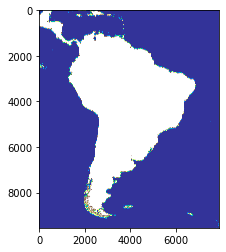

[ 9.133333  10.083333  11.466666  12.        10.841667   8.091667
  9.808333  14.216666   9.208334   9.133333   8.633333   9.866667
  6.2499995 12.816668  11.250001  10.733334   8.866667  13.441667
 11.791667   9.608334  12.333333   9.433333   9.658334  11.55
 12.041666  10.691667  10.5        8.308333   8.950001  12.224999
  8.783333   9.7        9.341666  13.         9.691668  13.283333
 15.3       11.591667   9.666667  10.125     12.041667  14.8
 12.108334   8.733334  13.025     13.508333  12.616667  11.816667
 10.108333  12.808333   9.575     10.466666  12.158333   9.241667
 10.841667  11.608334  11.625     12.841666  14.1       12.233334
  9.35      10.983334  10.183333   9.133333  10.083333  11.466666
 12.        10.841667   8.091667   9.808333 ]
Reading raster bio3_isothermality.tif


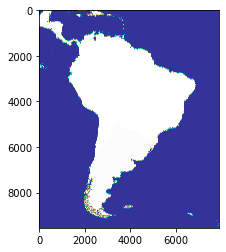

[86.16352  75.24876  70.78189  68.181816 75.81586  82.568016 83.121475
 70.37954  82.217255 82.282295 84.64052  50.084602 66.489365 72.410545
 79.787224 77.77779  85.2564   59.214394 71.90041  72.2431   74.74747
 88.99372  77.889786 72.64151  73.87526  72.241    80.76923  80.66344
 85.2381   63.01546  82.087234 58.083836 82.66961  62.20096  83.548836
 71.8018   68.       70.25252  87.87879  60.26786  70.00969  70.14218
 70.39729  86.46864  72.361115 75.88952  67.83154  57.362457 79.59318
 68.862    89.48597  79.29292  67.17312  82.51488  71.7991   71.65639
 57.26601  70.17304  75.40108  65.41889  68.75     69.07757  76.566414
 86.16352  75.24876  70.78189  68.181816 75.81586  82.568016 83.121475]
Reading raster bio4_temperature_seasonality.tif


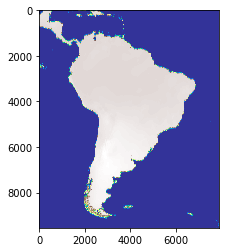

[ 41.27696   96.4208    40.945267 180.93193   49.610226  43.194
  43.07102  102.98573   38.698036  65.18621   38.2872   377.17252
 118.57743   33.777348  76.910034  67.2625    39.099735 343.3687
  54.20746   38.639286  90.57479   32.086525  55.519253 144.54213
  99.66898   41.09071   53.63316   52.676445  37.658745 211.10237
  60.40896  241.56215   29.628351 305.72565   72.4399   132.72495
 128.08615   57.133255  45.477257 212.62563   50.817177 110.39869
  49.747463  41.50575   87.18992  106.26136  183.41254  315.74466
  52.199722  89.31878   43.924458  57.977283  46.829376  57.739952
  39.83633   49.975384 311.82352  127.96409   94.75647  218.36166
 147.13683   41.056137  36.04501   41.27696   96.4208    40.945267
 180.93193   49.610226  43.194     43.07102 ]
Reading raster bio5_max_temperature_of_warmest_month.tif


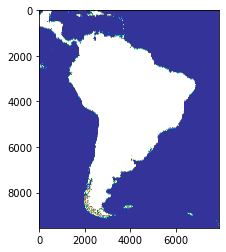

[32.  31.3 33.2 30.5 33.5 31.7 32.3 33.6 31.5 33.3 31.2 28.4 29.4 34.4
 34.9 33.5 31.2 30.  33.5 33.4 33.4 31.8 31.  29.9 33.6 32.8 30.9 32.3
 31.  33.7 31.4 26.  32.7 28.9 33.4 31.3 34.7 33.9 31.5 31.3 34.9 34.2
 33.3 31.5 33.8 31.9 30.3 26.7 31.4 33.9 32.2 31.6 35.6 32.5 32.9 34.3
 25.6 33.1 31.3 27.7 26.4 34.5 32.9 32.  31.3 33.2 30.5 33.5 31.7 32.3]
Reading raster bio6_min_temperature_of_coldest_month.tif


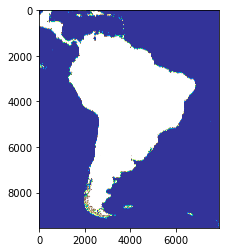

[21.4 17.9 17.  12.9 19.2 21.9 20.5 13.4 20.3 22.2 21.   8.7 20.  16.7
 20.8 19.7 20.8  7.3 17.1 20.1 16.9 21.2 18.6 14.  17.3 18.  17.9 22.
 20.5 14.3 20.7  9.3 21.4  8.  21.8 12.8 12.2 17.4 20.5 14.5 17.7 13.1
 16.1 21.4 15.8 14.1 11.7  6.1 18.7 15.3 21.5 18.4 17.5 21.3 17.8 18.1
  5.3 14.8 12.6  9.  12.8 18.6 19.6 21.4 17.9 17.  12.9 19.2 21.9 20.5]
Reading raster bio7_temperature_annual_range.tif


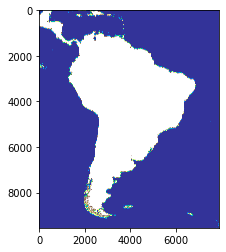

[10.6      13.4      16.2      17.6      14.299999  9.800001 11.799999
 20.199999 11.200001 11.099998 10.200001 19.7       9.4      17.7
 14.100002 13.799999 10.400002 22.7      16.4      13.300001 16.500002
 10.599998 12.4      15.9      16.3      14.799999 13.       10.299999
 10.5      19.400002 10.699999 16.7      11.300001 20.9      11.600002
 18.5      22.5      16.500002 11.       16.8      17.2      21.1
 17.199999 10.1      18.       17.8      18.599998 20.6      12.699999
 18.600002 10.700001 13.200001 18.099998 11.200001 15.100002 16.199999
 20.3      18.3      18.699999 18.7      13.599999 15.9      13.300001
 10.6      13.4      16.2      17.6      14.299999  9.800001 11.799999]
Reading raster bio8_mean_temperature_of_wettest_quarter.tif


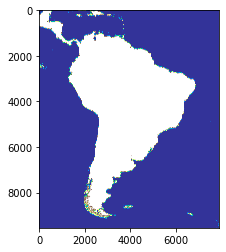

[25.933334 23.783333 25.283333 24.5      25.266666 26.133333 25.616667
 25.016666 26.099998 26.55     26.216667 22.366667 24.666668 24.75
 26.833334 26.016666 25.966667 23.066666 25.616667 26.4      24.733334
 26.183334 25.433332 23.466667 25.233334 25.55     25.2      26.133333
 25.816668 26.966667 24.916666 21.35     26.516666 22.233334 26.383333
 24.616667 24.966667 24.4      25.683334 25.033333 25.6      25.266666
 24.9      25.75     25.983334 25.266666 23.783333 20.55     25.6
 24.       26.1      25.6      25.6      25.983334 25.433334 25.1
 19.566666 26.133333 23.866667 21.816668 21.216667 25.483334 26.05
 25.933334 23.783333 25.283333 24.5      25.266666 26.133333 25.616667]
Reading raster bio9_mean_temperature_of_driest_quarter.tif


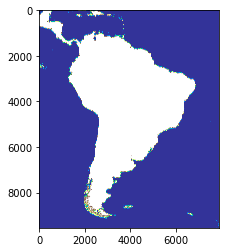

[26.85     24.716667 24.933334 20.733334 26.133333 26.533333 26.4
 23.05     25.566666 27.633333 25.9      13.7      25.916666 25.1
 27.933334 26.650002 25.75     14.833334 24.95     26.7      24.333332
 26.616667 24.333332 20.2      24.533333 25.183334 24.183332 27.4
 25.683332 22.366667 25.633333 15.533333 26.8      16.066668 27.666666
 21.783333 22.533333 25.333334 25.95     20.683334 25.966667 23.2
 24.533333 26.683334 24.366667 22.95     19.966667 12.916667 24.616667
 23.85     26.916666 24.533333 26.066666 27.1      25.133333 25.933334
 12.183333 23.699999 21.983334 16.65     18.416666 26.1      25.95
 26.85     24.716667 24.933334 20.733334 26.133333 26.533333 26.4     ]
Reading raster bio10_mean_temperature_of_warmest_quarter.tif


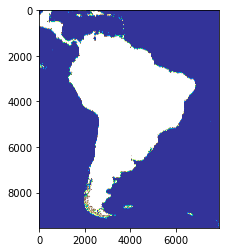

[26.883333 25.483334 25.7      24.55     26.516666 27.033333 26.6
 25.283333 26.483334 28.083334 26.483334 22.616667 26.083334 25.566668
 28.35     27.550001 26.35     23.066666 26.05     27.316668 26.35
 26.716667 25.616667 23.533333 26.866667 26.083334 25.483334 27.4
 26.183334 27.216667 26.3      21.433332 27.199999 22.233334 27.9
 24.8      25.75     25.833334 26.3      26.       26.766666 25.633333
 25.55     26.733334 26.35     25.416666 23.800001 20.55     25.85
 25.683334 27.066668 25.916666 26.699999 27.1      25.95     26.35
 19.566666 26.566666 24.2      21.883333 21.583334 26.45     26.65
 26.883333 25.483334 25.7      24.55     26.516666 27.033333 26.6     ]
Reading raster bio11_mean_temperature_of_coldest_quarter.tif


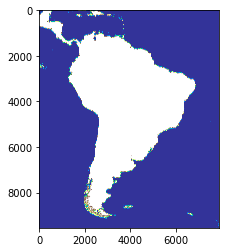

[25.85     23.116667 24.75     20.5      25.266666 26.05     25.533333
 23.05     25.55     26.533333 25.533333 13.7      23.216667 24.75
 26.566668 26.016666 25.416666 14.766666 24.75     26.4      24.116667
 25.983334 24.333332 20.2      24.316666 25.066668 24.183332 26.133333
 25.25     22.366667 24.816668 15.533333 26.516666 14.866667 26.316666
 21.766666 22.533333 24.4      25.283333 20.683334 25.6      23.15
 24.466667 25.716667 24.333334 22.95     19.633333 12.916667 24.616667
 23.616667 26.05     24.533333 25.6      25.683334 25.016666 25.1
 12.05     23.5      21.983334 16.65     18.       25.45     25.75
 25.85     23.116667 24.75     20.5      25.266666 26.05     25.533333]
Reading raster bio12_annual_precipitation.tif


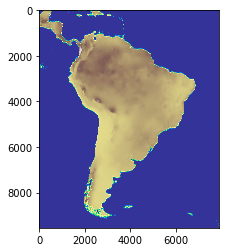

[2460.  668. 2240. 1433. 1822. 2390. 2358. 1693. 2781. 1669. 3400. 1494.
 1905. 1998. 1159. 1473. 3328. 1804. 2079. 2207.  898. 2608. 2089.  558.
  858. 2251. 2283. 2762. 2786. 1389. 1787. 1408. 2244. 1630. 1840. 1666.
  991. 1757. 3054. 1057. 1768. 1647. 2011. 2210. 1632. 1640. 1533. 1422.
 2094. 1516. 2016. 1740. 2142. 2298. 2237. 1785. 1479. 1697. 1781. 1619.
  599. 2032. 2368. 2460.  668. 2240. 1433. 1822. 2390. 2358.]
Reading raster bio13_precipitation_of_wettest_month.tif


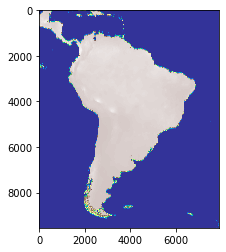

[426. 192. 334. 278. 315. 320. 336. 291. 332. 322. 349. 159. 310. 309.
 292. 313. 335. 207. 336. 326. 158. 333. 281. 101. 176. 338. 300. 457.
 286. 238. 335. 237. 291. 200. 351. 295. 184. 275. 336. 182. 271. 285.
 330. 422. 296. 262. 282. 168. 288. 284. 319. 241. 347. 347. 342. 275.
 170. 300. 289. 343. 120. 329. 352. 426. 192. 334. 278. 315. 320. 336.]
Reading raster bio14_precipitation_of_driest_month.tif


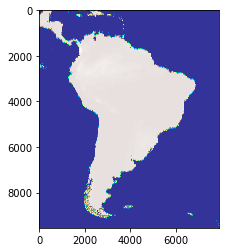

[ 47.   2.  17.  10.  24.  92.  65.   2. 104.  43. 228.  94.  74.  14.
   1.   9. 226. 105.  15.  29.   2. 162.  56.   2.   1.  18.  57.  45.
 155.  22.  53.  31.  66.  79.  40.  15.   0.  16. 195.  25.   6.   2.
   3.  62.   2.   6.  17.  74.  50.   0.  97.  36.   4.  47.  18.  14.
  81.  11.   4.  16.  10.   9.  36.  47.   2.  17.  10.  24.  92.  65.]
Reading raster bio15_precipitation_seasonality.tif


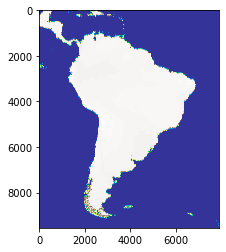

[ 71.13115  111.828575  66.3803    84.18205   68.17817   39.9876
  53.172447  83.81814   37.35025   70.38712   13.585182  17.521646
  48.313717  60.80633  111.56681   88.73724   13.438133  23.122318
  68.09626   58.995945  84.83061   26.76039   45.71943   83.97815
  88.8938    63.36563   48.084484  67.99831   21.49983   66.731636
  72.87374   65.43837   45.612354  25.254444  74.05565   73.206
  89.13564   66.5169    18.142225  59.623642  74.81039   82.70474
  77.63758   72.64473   80.35408   75.72322   77.7314    26.950048
  45.45079   85.994736  44.380493  52.30979   75.6544    56.005642
  63.548244  66.01422   24.25953   73.93189   78.523636  83.841156
  73.45468   69.94855   57.046474  71.13115  111.828575  66.3803
  84.18205   68.17817   39.9876    53.172447]
Reading raster bio16_precipitation_of_wettest_quarter.tif


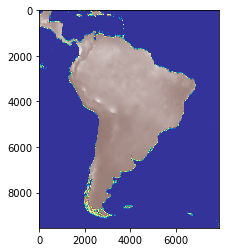

[1209.  443.  977.  747.  863.  901.  952.  864.  989.  865.  970.  453.
  818.  842.  756.  833.  937.  558.  940.  947.  439.  898.  788.  288.
  446.  968.  841. 1331.  844.  651.  958.  665.  834.  500.  968.  792.
  507.  809.  953.  482.  800.  833.  968. 1115.  808.  779.  768.  475.
  774.  778.  835.  669. 1005.  983.  958.  802.  482.  804.  860.  850.
  301.  893.  976. 1209.  443.  977.  747.  863.  901.  952.]
Reading raster bio17_precipitation_of_driest_quarter.tif


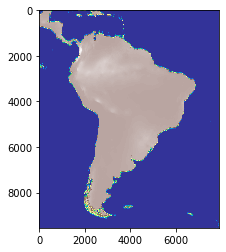

[180.  10.  80.  34. 101. 309. 228.  18. 350. 161. 698. 294. 275. 103.
   4.  47. 707. 375.  80. 130.  10. 500. 200.  15.   6. 108. 203. 168.
 485.  77. 211. 114. 228. 320. 154.  69.   3.  77. 600.  86.  29.  19.
  29. 199.  16.  39.  57. 268. 203.  10. 301. 138.  34. 190.  94.  69.
 285.  57.  34.  58.  38.  45. 144. 180.  10.  80.  34. 101. 309. 228.]
Reading raster bio18_precipitation_of_warmest_quarter.tif


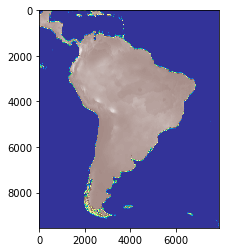

[182.  66. 313. 647. 206. 426. 233. 657. 647. 245. 767. 445. 318. 345.
  38. 122. 721. 558. 473. 455. 188. 516. 626. 246. 158. 502. 715. 168.
 594. 495. 228. 625. 456. 500. 283. 569. 249. 253. 764. 348. 238. 405.
 488. 279. 410. 615. 694. 475. 642. 285. 338. 552. 318. 190. 508. 262.
 482. 579. 687. 697. 220. 371. 528. 182.  66. 313. 647. 206. 426. 233.]
Reading raster bio19_precipitation_of_coldest_quarter.tif


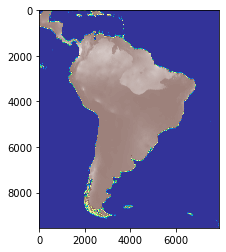

[1137.   72.  154.   51.  863.  801.  916.   18.  468.  773.  819.  294.
  442.  842.  729.  833.  841.  383.  138.  947.   24.  725.  200.   15.
   23.  193.  203. 1255.  638.   77.  838.  114.  834.  354.  904.   93.
    3.  747.  778.   86.  800.   41.   63. 1074.   48.   39.   76.  268.
  203.   52.  702.  138. 1005.  759.  199.  802.  289.   90.   34.   58.
   40.  892.  249. 1137.   72.  154.   51.  863.  801.  916.]
Reading raster elev1_strm_worldclim_elevation.tif


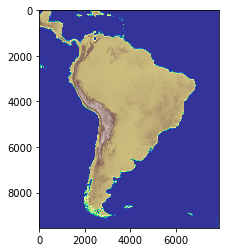

[ 14. 567. 127. 525. 173.  91.  18. 336. 119.  85. 103. 406.  41. 248.
  43.  71.  79. 420. 175. 117. 526.  61. 189. 694. 442.  88. 198.   6.
 105. 150. 408. 738.  65. 656. 124. 565. 456. 351.  75.  51. 178. 335.
 386.  55. 328. 291. 661. 808. 232. 523.  81. 251. 332.  27.  98. 217.
 970. 250. 538. 947. 832. 318.  76.  14. 567. 127. 525. 173.  91.  18.]
Reading raster elev2_envirem_terrain_roughness_index.tif


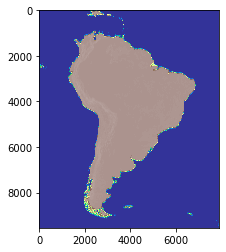

[ 5.75  8.88 13.   14.5  10.38  5.38  2.25  7.88  4.25  2.38  9.38 55.75
 17.88  6.    9.38  5.62  9.75 42.5  14.12  2.88  1.75  4.5   6.   18.62
  4.62  0.75  4.38  2.38  5.    0.38 91.   15.12  2.38 22.    5.12 19.5
  1.38 20.12  7.88 11.25  7.5   6.75 10.25  6.12 11.75  6.75 13.12 14.88
  3.88  3.88  7.75 12.25 18.62  6.    1.   18.62 44.75 22.5  16.12 25.38
 55.12  6.75  4.25  5.75  8.88 13.   14.5  10.38  5.38  2.25]
Reading raster elev3_envirem_topographic_wetness_index.tif


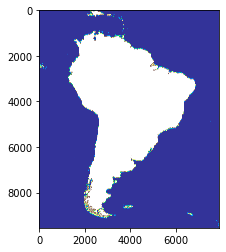

[12.29 11.91 11.74 11.31 11.67 12.4  13.04 12.38 13.14 11.48 12.13 10.22
 11.37 12.43 12.5  12.15 12.35 10.7  11.42 13.05 13.43 12.81 13.25 11.21
 11.67 13.07 12.33 13.33 13.   14.28  9.82 11.4  13.19 10.93 12.9  10.94
 13.71 11.26 12.94 11.93 12.5  11.39 11.45 12.14 11.76 11.65 11.12 11.29
 13.18 12.4  12.23 12.09 10.73 12.94 13.32 11.71 10.65 10.18 11.41 10.72
 10.19 12.18 12.38 12.29 11.91 11.74 11.31 11.67 12.4  13.04]
Reading raster envir1_annual_PET.tif


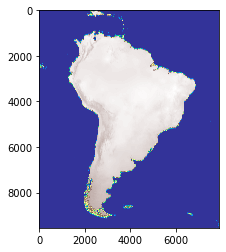

[1741.33 1618.82 1748.12 1744.55 1719.17 1601.1  1735.23 1914.54 1678.71
 1735.78 1591.62 1286.18 1378.84 1838.01 1865.18 1749.2  1590.01 1545.06
 1755.11 1717.3  1867.44 1677.53 1635.62 1603.44 1879.38 1696.55 1731.85
 1659.08 1607.94 1759.86 1634.32 1319.07 1625.03 1513.41 1747.81 1782.56
 1972.16 1763.63 1615.56 1496.7  1893.49 1896.89 1874.4  1706.9  1892.87
 1799.69 1702.89 1375.12 1700.33 1831.07 1730.39 1727.82 1943.6  1652.18
 1710.15 1820.97 1337.57 1811.91 1798.48 1515.32 1399.32 1917.34 1690.64
 1741.33 1618.82 1748.12 1744.55 1719.17 1601.1  1735.23]
Reading raster envir2_aridity_index_thornthwaite.tif


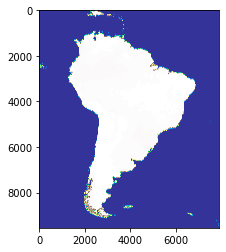

[45.84 75.62 56.12 61.25 50.55 15.6  35.66 83.98 26.62 62.47  0.    5.34
 31.32 57.81 84.08 69.06  0.   18.64 49.12 57.03 56.8   0.   36.59 66.57
 61.15 44.62 46.5  55.58  0.   49.75 73.88 38.67 31.71 10.82 56.7  66.58
 52.44 70.38  0.   42.4  79.61 61.46 74.9  42.38 69.84 64.42 62.72 12.55
 39.15 81.3  30.06 47.72 77.51 42.26 45.6  72.98 16.46 64.84 65.06 67.
 57.41 70.61 52.59 45.84 75.62 56.12 61.25 50.55 15.6  35.66]
Reading raster envir3_climatic_moisture_index.tif


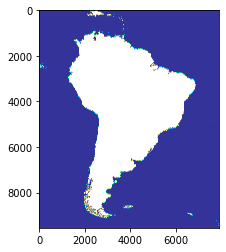

[ 0.31 -0.59  0.19 -0.27  0.11  0.35  0.25  0.04  0.41 -0.06  0.55  0.15
  0.21  0.08 -0.42 -0.11  0.54  0.14  0.21  0.22 -0.52  0.35  0.24 -0.67
 -0.55  0.22  0.28  0.36  0.44 -0.24 -0.34  0.03  0.37  0.1  -0.08 -0.12
 -0.52 -0.03  0.47 -0.31  0.08 -0.07  0.09  0.26 -0.09 -0.1  -0.17 -0.06
  0.21 -0.18  0.13  0.    0.11  0.28  0.22  0.01  0.04 -0.09 -0.04  0.06
 -0.57  0.19  0.28  0.31 -0.59  0.19 -0.27  0.11  0.35  0.25]
Reading raster envir4_continentality.tif


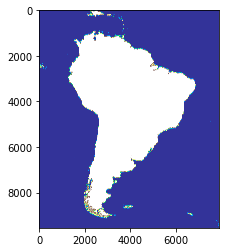

[0.85 2.55 1.55 4.9  1.1  1.3  1.1  3.25 1.15 1.9  1.2  9.75 3.6  0.9
 1.85 1.65 1.25 9.1  1.75 1.15 2.45 1.   2.   3.7  2.6  1.75 1.5  1.1
 1.   4.9  1.65 6.55 1.1  8.1  1.8  3.8  4.05 1.25 1.35 5.55 1.2  3.4
 2.55 0.9  2.65 3.25 5.   8.65 1.9  2.3  1.2  1.95 2.3  1.75 1.7  1.2
 8.7  3.25 3.15 5.75 4.2  1.6  1.15 0.85 2.55 1.55 4.9  1.1  1.3  1.1 ]
Reading raster envir5_embergers_pluviothermic_quotient.tif


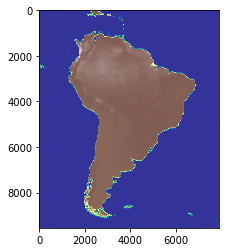

[ 741.99  168.83  440.66  225.77  517.94  799.56  658.27  315.47  811.07
  457.58 1157.9   263.41  544.11  422.8   256.85  408.97 1129.19  272.
  480.06  491.16  185.17  815.05  540.35  123.5   177.84  505.81  606.31
  833.42  901.72  248.41  316.93  276.78  774.03  272.19  445.54  289.12
  142.31  376.41  996.96  215.73  408.41  291.97  363.63  676.61  310.08
  321.86  254.41  214.52  519.26  290.71  595.4   410.97  349.86  690.96
  486.51  397.68  229.03  297.5   324.11  298.48  146.42  398.02  596.37
  741.99  168.83  440.66  225.77  517.94  799.56  658.27]
Reading raster envir6_growing_deg_days_0.tif


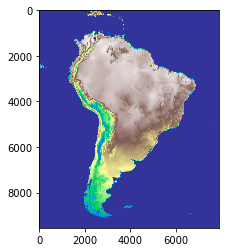

[116586. 103860. 109782. 103572. 113382. 116874. 115686. 106830. 111114.
 117324. 110556.  78624. 107694. 108360. 119646. 117180. 111024.  82854.
 110214. 114840. 110538. 114966. 109494.  96840. 112572. 113058. 110862.
 117036. 110088. 112410. 110628.  79740. 114084.  80784. 116190. 101844.
 106218. 109404. 113922. 101916. 114912. 107154. 107352. 114930. 111744.
 107352.  99432.  74538. 111132. 108036. 116028. 111492. 108774. 116892.
 112176. 112086.  70038. 104076. 102492.  85266.  86940. 108828. 113922.
 116586. 103860. 109782. 103572. 113382. 116874. 115686.]
Reading raster envir7_growing_deg_days_5.tif


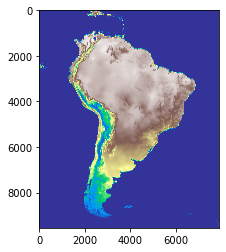

[116586. 103860. 109782. 103572. 113382. 116874. 115686. 106830. 111114.
 117324. 110556.  78624. 107694. 108360. 119646. 117180. 111024.  82854.
 110214. 114840. 110538. 114966. 109494.  96840. 112572. 113058. 110862.
 117036. 110088. 112410. 110628.  79740. 114084.  80784. 116190. 101844.
 106218. 109404. 113922. 101916. 114912. 107154. 107352. 114930. 111744.
 107352.  99432.  74538. 111132. 108036. 116028. 111492. 108774. 116892.
 112176. 112086.  70038. 104076. 102492.  85266.  86940. 108828. 113922.
 116586. 103860. 109782. 103572. 113382. 116874. 115686.]
Reading raster envir8_max_temp_coldest.tif


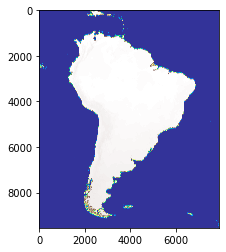

[310. 276. 309. 285. 302. 305. 307. 319. 302. 310. 293. 183. 262. 320.
 313. 315. 293. 212. 312. 330. 314. 306. 298. 254. 316. 310. 308. 306.
 295. 298. 289. 207. 301. 199. 307. 293. 323. 295. 296. 264. 339. 315.
 318. 303. 321. 305. 273. 190. 305. 317. 309. 310. 329. 303. 308. 303.
 181. 305. 298. 236. 225. 326. 318. 310. 276. 309. 285. 302. 305. 307.]
Reading raster envir9_min_temp_warmest.tif


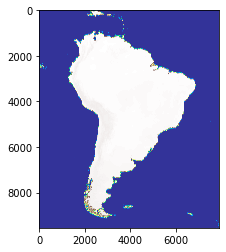

[218. 198. 196. 194. 213. 231. 215. 184. 210. 232. 216. 181. 227. 186.
 223. 223. 217. 170. 207. 213. 204. 221. 209. 183. 210. 212. 210. 227.
 209. 228. 212. 169. 222. 161. 225. 185. 188. 191. 220. 214. 207. 187.
 180. 215. 200. 204. 192. 155. 210. 190. 223. 211. 175. 228. 213. 193.
 145. 185. 190. 166. 170. 177. 214. 218. 198. 196. 194. 213. 231. 215.]
Reading raster envir10_month_count_by_temp_10.tif


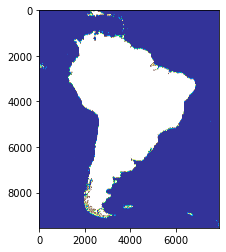

[12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.]
Reading raster envir11_PET_coldest_quarter.tif


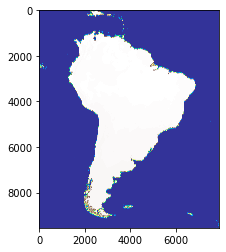

[141.71 112.72 130.78 112.68 143.56 132.26 139.51 141.89 124.18 137.59
 117.41  55.75  87.38 143.89 136.51 130.39 117.32  73.48 127.17 136.77
 140.07 126.7  118.48 107.14 140.23 128.16 129.34 134.91 118.56 111.99
 126.07  78.65 135.8   73.37 137.48 121.12 152.12 146.73 123.68  93.13
 148.44 137.82 140.87 135.9  136.91 127.37 106.58  72.26 122.79 140.17
 131.49 125.28 148.2  132.83 128.05 151.89  69.74 123.87 128.14  90.19
  91.76 152.95 125.57 141.71 112.72 130.78 112.68 143.56 132.26 139.51]
Reading raster envir12_PET_driest_quarter.tif


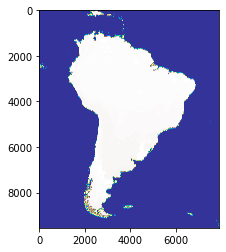

[156.25 146.55 142.23 119.27 140.46 138.63 157.35 151.82 128.58 150.81
 130.84  60.01 139.69 150.14 171.76 150.54 139.83  97.92 138.66 146.94
 143.06 147.95 127.48 120.95 142.76 137.93 135.05 148.77 132.95 118.88
 135.61  78.65 129.42  97.31 150.55 129.45 152.12 147.91 144.39  93.13
 155.06 147.15 150.43 155.54 147.19 130.97 113.38  68.21 131.06 147.61
 148.18 133.2  160.49 151.67 138.81 151.69  65.74 133.58 132.59  95.88
 103.22 159.63 134.54 156.25 146.55 142.23 119.27 140.46 138.63 157.35]
Reading raster envir13_PET_seasonality.tif


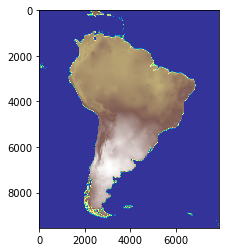

[ 790.49 1733.99 1363.81 2260.5   706.94  816.26  959.02 1590.47 1079.74
  820.98  988.22 4207.19 2286.84  955.43 1726.05 1348.74  992.68 4321.26
 1496.09 1131.7  1356.92  877.96 1327.83 2197.87 1432.56 1190.35 1041.35
  738.2  1035.95 2541.48  862.82 2604.1  1052.21 4098.2   833.54 1901.21
 1714.4   559.78 1020.79 2715.07  791.34 1613.71 1378.83  905.79 1622.99
 1689.2  2476.97 3710.27 1364.36 1203.03  844.23 1336.15 1573.23 1009.08
 1342.22  629.99 3673.76 1876.59 1601.78 2595.66 2019.08 1543.57 1155.74
  790.49 1733.99 1363.81 2260.5   706.94  816.26  959.02]
Reading raster envir14_PET_warmest_quarter.tif


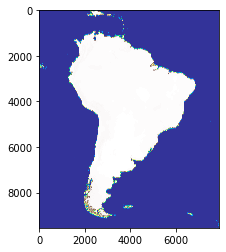

[155.02 154.83 160.96 160.32 151.85 143.73 157.35 179.92 151.01 148.04
 139.21 153.62 135.35 165.27 174.01 163.53 138.99 178.08 160.83 159.09
 171.83 147.95 147.63 149.55 173.74 155.35 153.55 147.54 144.53 170.41
 143.21 131.62 147.49 172.5  147.69 163.73 184.65 152.72 144.39 152.73
 166.32 178.32 172.5  155.54 177.4  158.01 157.73 146.02 153.58 168.2
 147.84 158.42 183.83 151.48 157.67 159.8  154.39 169.41 165.15 147.82
 134.72 178.76 153.11 155.02 154.83 160.96 160.32 151.85 143.73 157.35]
Reading raster envir15_PET_wettest_quarter.tif


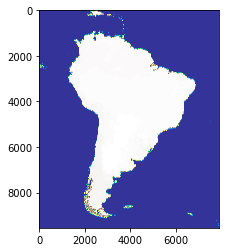

[142.26 129.49 143.27 164.88 140.36 127.64 139.51 159.21 144.27 137.59
 137.02 141.16  91.77 146.84 144.8  139.61 122.01 178.08 146.76 136.77
 156.63 129.91 139.31 154.   158.33 144.01 148.97 136.12 138.57 167.97
 125.16 138.61 133.46 172.5  133.24 162.46 172.84 143.31 124.99 153.12
 156.02 160.86 157.47 136.32 162.13 162.73 163.55 157.69 145.87 148.59
 131.49 147.24 156.69 130.83 139.66 148.66 154.39 158.25 160.6  152.21
 135.34 152.95 142.16 142.26 129.49 143.27 164.88 140.36 127.64 139.51]
Reading raster envir16_thermicity_index.tif


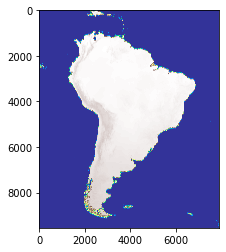

[713.5 628.5 658.5 612.  687.  721.  710.  640.5 677.5 723.  676.  456.
 655.  661.  728.5 723.5 678.5 479.  672.5 707.5 679.5 706.  663.  572.
 694.  687.5 676.  720.  673.  677.  673.5 457.5 696.  456.  714.  608.
 645.5 649.5 695.5 618.5 709.  643.  651.5 699.  674.5 646.5 585.  422.5
 675.  664.  712.  680.5 663.  722.5 677.  668.  393.  623.5 611.5 493.5
 505.  660.  701.5 713.5 628.5 658.5 612.  687.  721.  710. ]
------------------------------------------------------



In [ ]:
env_info_species_absence_df,env_info_species_absence_path = raster_collector.create_env_info_species_absence_df(species_name= species_name_string,
                                   list_raster_files=list_raster_files,
                                   list_names_raster=list_names_raster,
                                   presence_absence_folder_path = presence_absence_folder_path,
                                   species_env_info_folder_path = species_env_info_folder_path,
                                   verbose = True)


In [ ]:
env_info_species_absence_df

,bio1_annual_mean_temperature,bio2_mean_diurnal_range,bio3_isothermality,bio4_temperature_seasonality,bio5_max_temperature_of_warmest_month,bio6_min_temperature_of_coldest_month,bio7_temperature_annual_range,bio8_mean_temperature_of_wettest_quarter,bio9_mean_temperature_of_driest_quarter,bio10_mean_temperature_of_warmest_quarter,bio11_mean_temperature_of_coldest_quarter,bio12_annual_precipitation,bio13_precipitation_of_wettest_month,bio14_precipitation_of_driest_month,bio15_precipitation_seasonality,bio16_precipitation_of_wettest_quarter,bio17_precipitation_of_driest_quarter,bio18_precipitation_of_warmest_quarter,bio19_precipitation_of_coldest_quarter,elev1_strm_worldclim_elevation,elev2_envirem_terrain_roughness_index,elev3_envirem_topographic_wetness_index,envir1_annual_PET,envir2_aridity_index_thornthwaite,envir3_climatic_moisture_index,envir4_continentality,envir5_embergers_pluviothermic_quotient,envir6_growing_deg_days_0,envir7_growing_deg_days_5,envir8_max_temp_coldest,envir9_min_temp_warmest,envir10_month_count_by_temp_10,envir11_PET_coldest_quarter,envir12_PET_driest_quarter,envir13_PET_seasonality,envir14_PET_warmest_quarter,envir15_PET_wettest_quarter,envir16_thermicity_index
0,26.408333,9.133333,86.163521,41.276958,32.000000,21.400000,10.600000,25.933334,26.850000,26.883333,25.850000,2460.0,426.0,47.0,71.131149,1209.0,180.0,182.0,1137.0,14.0,5.75,12.29,1741.329956,45.840000,0.31,0.85,741.989990,116586.0,116586.0,310.0,218.0,12.0,141.710007,156.250000,790.489990,155.020004,142.259995,713.5
1,24.233334,10.083333,75.248756,96.420799,31.299999,17.900000,13.400000,23.783333,24.716667,25.483334,23.116667,668.0,192.0,2.0,111.828575,443.0,10.0,66.0,72.0,567.0,8.88,11.91,1618.819946,75.620003,-0.59,2.55,168.830002,103860.0,103860.0,276.0,198.0,12.0,112.720001,146.550003,1733.989990,154.830002,129.490005,628.5
2,25.291666,11.466666,70.781891,40.945267,33.200001,17.000000,16.200001,25.283333,24.933334,25.700001,24.750000,2240.0,334.0,17.0,66.380302,977.0,80.0,313.0,154.0,127.0,13.00,11.74,1748.119995,56.119999,0.19,1.55,440.660004,109782.0,109782.0,309.0,196.0,12.0,130.779999,142.229996,1363.810059,160.960007,143.270004,658.5
3,23.200001,12.000000,68.181816,180.931931,30.500000,12.900000,17.600000,24.500000,20.733334,24.549999,20.500000,1433.0,278.0,10.0,84.182053,747.0,34.0,647.0,51.0,525.0,14.50,11.31,1744.550049,61.250000,-0.27,4.90,225.770004,103572.0,103572.0,285.0,194.0,12.0,112.680000,119.269997,2260.500000,160.320007,164.880005,612.0
4,25.920834,10.841667,75.815857,49.610226,33.500000,19.200001,14.299999,25.266666,26.133333,26.516666,25.266666,1822.0,315.0,24.0,68.178169,863.0,101.0,206.0,863.0,173.0,10.38,11.67,1719.170044,50.549999,0.11,1.10,517.940002,113382.0,113382.0,302.0,213.0,12.0,143.559998,140.460007,706.940002,151.850006,140.360001,687.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,25.291666,11.466666,70.781891,40.945267,33.200001,17.000000,16.200001,25.283333,24.933334,25.700001,24.750000,2240.0,334.0,17.0,66.380302,977.0,80.0,313.0,154.0,127.0,13.00,11.74,1748.119995,56.119999,0.19,1.55,440.660004,109782.0,109782.0,309.0,196.0,12.0,130.779999,142.229996,1363.810059,160.960007,143.270004,658.5
66,23.200001,12.000000,68.181816,180.931931,30.500000,12.900000,17.600000,24.500000,20.733334,24.549999,20.500000,1433.0,278.0,10.0,84.182053,747.0,34.0,647.0,51.0,525.0,14.50,11.31,1744.550049,61.250000,-0.27,4.90,225.770004,103572.0,103572.0,285.0,194.0,12.0,112.680000,119.269997,2260.500000,160.320007,164.880005,612.0
67,25.920834,10.841667,75.815857,49.610226,33.500000,19.200001,14.299999,25.266666,26.133333,26.516666,25.266666,1822.0,315.0,24.0,68.178169,863.0,101.0,206.0,863.0,173.0,10.38,11.67,1719.170044,50.549999,0.11,1.10,517.940002,113382.0,113382.0,302.0,213.0,12.0,143.559998,140.460007,706.940002,151.850006,140.360001,687.0
68,26.420834,8.091667,82.568016,43.194000,31.700001,21.900000,9.800001

## Plottig the points on the map

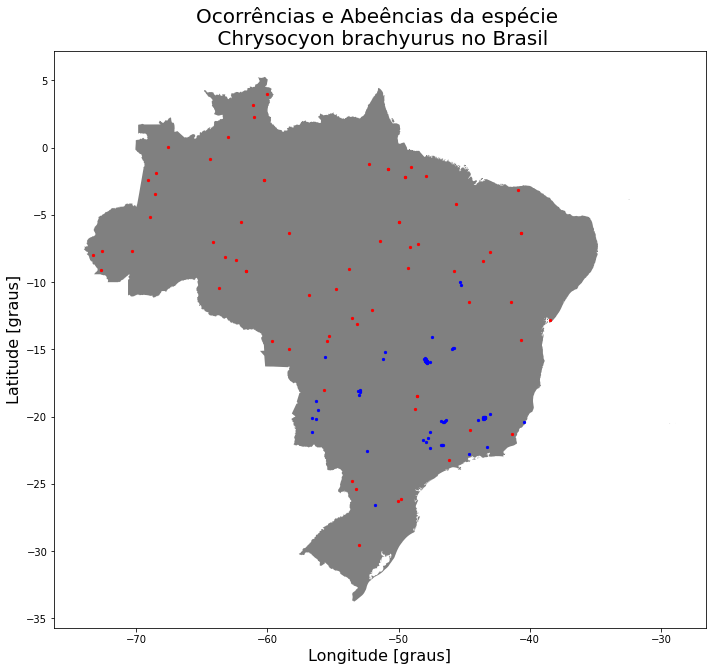

In [ ]:
map_result_species_folder_path = os.path.join(map_result_folder_path,species_name_string)
utils_methods.create_folder_structure(map_result_species_folder_path)

brazil_object.plot_points_on_country(species_name=species_name,
                              map_result_path = f"{map_result_species_folder_path}/{species_name_string}.png",
                              species_presences_path = species_presence_path,
                              species_absences_path=species_absence_path)

## Getting Dataframes for the Auxiliar Species

In [ ]:
aux_species_df = study_information_df[study_information_df['Study_Focus']==False]
aux_species_df

,GBIF_ID,Species_Name,Study_Focus
1,2732686,Attalea maripa,False
2,7413879,Acrocomia aculeata,False
3,2732758,Attalea phalerata,False


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


------------------------------------------------------

------------------------------------------------------



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


------------------------------------------------------

------------------------------------------------------



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


------------------------------------------------------

------------------------------------------------------



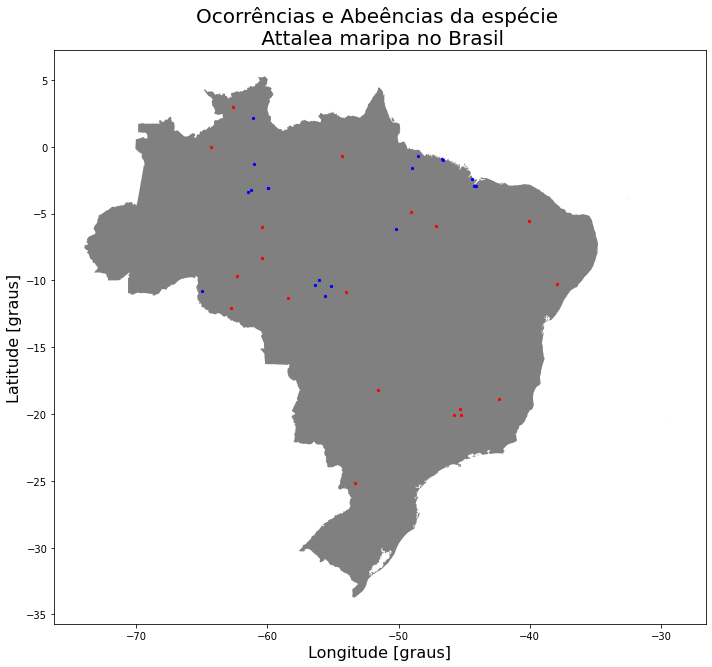

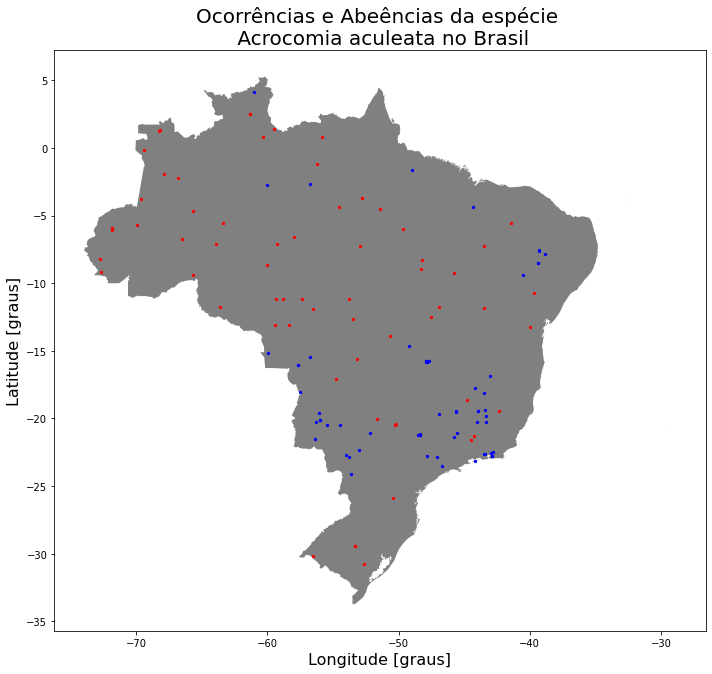

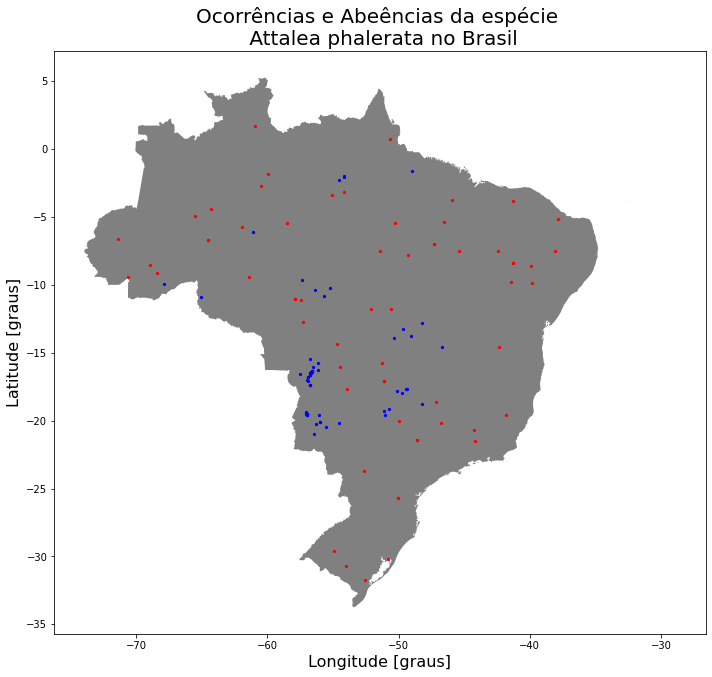

In [ ]:
raster_collector.reset_dataframes()

for index, row in aux_species_df.iterrows():
  aux_specie = row["Species_Name"]
  aux_specie_string = aux_specie.replace(" ","_")
  
  aux_specie_shp_path = os.path.join(occurrences_root,aux_specie_string,aux_specie_string+".shp")
  _,aux_species_presence_path = raster_collector.create_species_presence_df(specie_dir = aux_specie_shp_path,
                                                        species_name = aux_specie_string)
  
  _,aux_env_info_species_presence_path = raster_collector.create_env_info_species_presence_df(species_name=aux_specie_string,
                                                        list_raster_files=list_raster_files,
                                                        list_names_raster=list_names_raster,
                                                        presence_absence_folder_path=presence_absence_folder_path,
                                                        species_env_info_folder_path=species_env_info_folder_path)
  
  _,aux_species_absence_path = raster_collector.create_species_absence_df(species_name = aux_specie_string,
                                                        min_absence_distance = min_absence_distance,
                                                        presence_absence_folder_path = presence_absence_folder_path,
                                                        brazil_coordinate_points_path = brazil_coordinate_points)
  
  _,aux_env_info_species_absence_path = raster_collector.create_env_info_species_absence_df(species_name= aux_specie_string,
                                                        list_raster_files=list_raster_files,
                                                        list_names_raster=list_names_raster,
                                                        presence_absence_folder_path = presence_absence_folder_path,
                                                        species_env_info_folder_path = species_env_info_folder_path)
  
  
  map_result_species_folder_path = os.path.join(map_result_folder_path,aux_specie_string)
  utils_methods.create_folder_structure(map_result_species_folder_path)
  brazil_object.plot_points_on_country(species_name=aux_specie,
                                      map_result_path = f"{map_result_species_folder_path}/{aux_specie_string}.png",
                                      species_presences_path = aux_species_presence_path,
                                      species_absences_path=aux_species_absence_path)
  
  raster_collector.reset_dataframes()
  
